<a href="https://colab.research.google.com/github/Requenamar3/Machine-Learning/blob/main/Machie_Learning_2_Default_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 **Applying Naïve Bayes for Credit Default Prediction**


### 🔍 **Import Necessary Libraries**

In [80]:
# Import necessary libraries
import numpy as np  # For numerical operations and array manipulation
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For visualization

# Import machine learning components from scikit-learn
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes model
from sklearn.model_selection import train_test_split, KFold  # Splitting dataset and K-Fold cross-validation

# Import evaluation metrics
from sklearn.metrics import (
    confusion_matrix,  # To evaluate classification performance
    classification_report,  # To generate a detailed classification report
    roc_auc_score,  # To calculate the ROC AUC score
    roc_curve,  # To plot the Receiver Operating Characteristic (ROC) curve
    ConfusionMatrixDisplay  # To visualize the confusion matrix
)

from sklearn.model_selection import GridSearchCV  # Import GridSearchCV for hyperparameter tuning
from sklearn.tree import DecisionTreeClassifier, plot_tree # Import DecisionTreeClassifier and plot_tree

---
### 📌 **Load and Explore the Dataset**

In [2]:
# Load dataset from an online source
url = 'https://raw.githubusercontent.com/Requenamar3/Machine-Learning/refs/heads/main/Default.csv'
default_df = pd.read_csv(url)

# Display basic dataset information
default_df.info()  # Column types and missing values
default_df.head()  # First few rows of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


### 📌 **Convert Categorical Variables**

In [3]:
# Convert categorical variable "student" into a numeric format
default_df_dummies = pd.get_dummies(default_df, columns=['student'], drop_first=True)
default_df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      10000 non-null  object 
 1   balance      10000 non-null  float64
 2   income       10000 non-null  float64
 3   student_Yes  10000 non-null  bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 244.3+ KB


 **🤔 Why do we do this?**
- Machine learning models **work with numbers, not text**.
- **One-hot encoding** (converting categories into 0s and 1s) ensures that the model **understands categorical data**.
- **`drop_first=True`** prevents redundancy by keeping only **one binary column** for `student`.

✅ **Real-Life Example:**
Imagine an **e-commerce company** 🛒 analyzing customer data.
- Instead of "Gold", "Silver", and "Bronze" memberships as text labels, they use **numbers (0s and 1s)**.
- This way, the AI can determine if **Gold members spend more** without confusion.

---

---

### 📌 **Split Data into Training and Testing Sets**

Scikit-learn documentation about NB:

https://scikit-learn.org/stable/modules/naive_bayes.html


In [4]:
# Separate predictors and target variable
X_all = default_df_dummies.drop('default', axis=1)
y_default = default_df_dummies['default']

In [5]:
# Calculate the proportion of each unique value in the target variable (y_default)
# This helps to check class distribution and identify any imbalance in the dataset
y_default.value_counts(normalize=True)

,proportion
default,
No,0.9667
Yes,0.0333


In [6]:
# Preserve class balance when splitting data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_default, test_size=0.2, random_state=1, stratify=y_default)

In [7]:

# Check class distribution in train and test sets
y_train.value_counts(normalize=True)

,proportion
default,
No,0.96675
Yes,0.03325


In [8]:
y_test.value_counts(normalize=True)

,proportion
default,
No,0.9665
Yes,0.0335


**🤔 Why do we do this?**
- **Stratification** ensures that the **train and test sets have the same proportion** of "default" and "no default" cases.
- Checking **class distribution before and after splitting** helps ensure that **both sets are representative**.
- Prevents **bias**, ensuring the model isn’t trained on **imbalanced data**.

✅ **Real-Life Example:**
Imagine a **fraud detection team** 💳 training an AI model to detect **credit card fraud**.
- If the **fraud cases (minority class) aren’t well-represented**, the model might **fail to detect fraud**.
- **Stratified splitting** ensures that both **fraudulent and non-fraudulent transactions are present** in both training and test data.

---

Compared to the whole dataset, do the proportions of 'No' and 'Yes' remain similar in the train and test datasets?

**1. Do the Proportions of 'No' and 'Yes' Remain Similar in Train & Test Sets?**
Yes! Based on the results, the proportions of 'No' (non-default) and 'Yes' (default) are almost identical in both the training and test sets:

| **Dataset** | **No (Non-Default)** | **Yes (Default)** |
|------------|----------------------|------------------|
| **Train Set** | 96.675% | 3.325% |
| **Test Set** | 96.65% | 3.35% |

This means the train-test split **preserved the class distribution**, which is good because it ensures the model will be trained and tested on similar data.

---

**2. Why Is This Important?**
Think of it like training a dog with different types of treats. If you use 90% chicken treats in training and suddenly switch to 50% beef in testing, the dog might not respond the same way. Similarly, if the data proportions in training and testing are very different, the model might struggle to perform well on new data.

By keeping the proportions similar, we ensure the model learns patterns that apply equally to both training and real-world testing data.

---

**3. Understanding Naïve Bayes Hyperparameters**
The text mentions **two key settings (hyperparameters)** used in Naïve Bayes:

**A. `priors` (Default = None)**
- This determines the **starting assumption** about how common each class is.
- If set to `None`, the model will **learn** from the data.
- If manually specified, the model will **use the given values and ignore the actual data**.

✅ **Real-life example:** Imagine a weather app predicting rain or no rain. If it has no past data, it might assume a 50-50 chance. But if it learns that historically, it only rains 20% of the time, it will adjust its predictions accordingly. Setting priors manually would force it to stick with a fixed assumption, even if it’s wrong.

---

**B. `var_smoothing` (Default = 1e-9)**
- This helps prevent errors when working with **very small probabilities**.
- It ensures the model doesn’t accidentally treat rare events as impossible.

✅ **Real-life example:** Imagine an online store that sells 1,000 different products, but one rare product has only sold **twice** in the last year. If the store’s system rounds this to zero, it might **never recommend that product again**, even though someone might still buy it. `var_smoothing` ensures that rare events still have a small chance of being considered.

---

**Final Takeaways**
✅ The train-test split **kept class proportions nearly identical**, meaning the model won’t be biased by an uneven distribution.
✅ **Naïve Bayes automatically learns class probabilities**, but `priors` can be manually set if needed.
✅ **`var_smoothing` prevents calculation errors**, making sure rare events still have a chance of being recognized.


There are two hyperparameters only in NB and usually the default values are used (which means that usually no hyperparameter is tuned when applying NB):

_priors:_ array-like of shape (n_classes,), default=None

Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.

_var_smoothing:_ float, default=1e-9

Portion of the largest variance of all features that is added to variances for calculation stability.

---

### 📌 **Train the Naïve Bayes Model**

In [9]:
# Train the Naïve Bayes classifier
nb_classifier_default = GaussianNB()
nb_classifier_default.fit(X_train, y_train)

GaussianNB()


**🤔 Why do we do this?**
- **Naïve Bayes** calculates probabilities based on the assumption that **features are independent**.
- It is **fast and works well with small datasets**.

✅ **Real-Life Example:**
Imagine a **spam detection system** 📧.
- If an email contains words like "free", "win", or "urgent", **NB estimates the probability** of it being spam.
- Even if it **doesn’t analyze sentence meaning**, it is **still highly effective**.

---


### 📌 **Make Predictions with the Trained Model**

In [10]:
# Generate predictions on the test dataset
y_pred_test_default = nb_classifier_default.predict(X_test)

**🤔 Why do we do this?**
- Once the model is trained, we use it to **predict default cases on unseen data**.
- Helps **evaluate how well the model generalizes** to new customers.

✅ **Real-Life Example:**
Imagine a **bank loan system** 🏦 where a new applicant applies for a loan.
- The system takes their financial history and **predicts if they are likely to default** before approving the loan.

---

### 📌 **Evaluate Model Performance with a Confusion Matrix**

In [11]:
# Compute confusion matrix to assess correct and incorrect predictions
conf_matrix = confusion_matrix(y_test, y_pred_test_default)

In [12]:
# Retrieve the unique class labels recognized by the trained Naive Bayes classifier
# This confirms which classes the model has been trained to predict
nb_classifier_default.classes_


array(['No', 'Yes'], dtype='<U3')

In [13]:

# Format it for better visualization
df_conf_mattrix = pd.DataFrame(conf_matrix, index=['Actual_No','Actual_Yes'], columns=['Pred_No','Pred_Yes'])

df_conf_mattrix

,Pred_No,Pred_Yes
Actual_No,1924,9
Actual_Yes,48,19


---
- **True Negative (TN) = 1924** → The model correctly predicted "No" when the actual value was "No."
- **False Positive (FP) = 9** → The model incorrectly predicted "Yes" when the actual value was "No."
- **False Negative (FN) = 48** → The model incorrectly predicted "No" when the actual value was "Yes."
- **True Positive (TP) = 19** → The model correctly predicted "Yes" when the actual value was "Yes."

---

**Key Observations:**
1. **High TN Value (1924)**: The model performs well in predicting "No" correctly.
2. **Low TP Value (19)**: The model struggles to correctly classify "Yes" cases.
3. **More FN (48) than FP (9)**: The model is missing more actual "Yes" cases than misclassifying "No" cases as "Yes."
4. **Possible Imbalance**: Since the number of "No" samples is much higher than "Yes," the dataset might be imbalanced, affecting the model’s performance in detecting "Yes."

---


**🤔 Why do we do this?**
- The confusion matrix **reveals the types of errors** the model makes.
- It shows **false positives (wrongly predicted defaults)** and **false negatives (missed actual defaults)**.

✅ **Real-Life Example:**
Imagine an **airport security system** ✈️.
- A **False Positive** means an innocent traveler is wrongly flagged as a security threat.
- A **False Negative** means an actual threat is **missed**, leading to **high risk**.
- The confusion matrix helps improve the accuracy of **security screenings**.

---

### 📌 **Generate Classification Report**

In [14]:
# Generate a classification report with precision, recall, and F1-score
print(classification_report(y_test, y_pred_test_default))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      1933
         Yes       0.68      0.28      0.40        67

    accuracy                           0.97      2000
   macro avg       0.83      0.64      0.69      2000
weighted avg       0.97      0.97      0.97      2000



overall accuracy is 97
accuracy of the no class 1
accuracy of the yes class .28



**🤔 Why do we do this?**
- **Precision** tells us how many of the predicted defaults were **actually correct**.
- **Recall** shows how many of the actual defaults were **correctly identified**.
- **F1-score** balances precision and recall to measure **overall model effectiveness**.

✅ **Real-Life Example:**
Imagine a **medical diagnosis system** 🏥 detecting cancer.
- **High precision** means **most diagnosed cases actually have cancer**.
- **High recall** means **we are catching most cancer cases**.
- If recall is low, **some patients will go undiagnosed**, making the model dangerous.

---

**bold text**### **4. Analyzing the Model's Performance**
Your model’s classification report provides key insights into how well it predicts defaults ("Yes") and non-defaults ("No"). Here’s a breakdown:

| **Metric**   | **No (Non-Default)** | **Yes (Default)** |
|-------------|----------------------|------------------|
| **Precision** | 0.98 | 0.68 |
| **Recall**   | 1.00 | 0.28 |
| **F1-Score** | 0.99 | 0.40 |
| **Support**  | 1933 | 67 |

✅ **Interpretation:**
- The model is **very good at predicting "No" (non-defaulters)** with **98% precision** and **100% recall**.
- However, it **struggles to correctly identify "Yes" (defaulters)**:
  - **Precision for "Yes" is 68%**, meaning when it predicts a default, it is right 68% of the time.
  - **Recall for "Yes" is only 28%**, meaning it only finds 28% of actual defaulters.
- The **overall accuracy is 97%**, but this is misleading because most cases are "No." Accuracy is not a great metric for imbalanced datasets.

✅ **Real-life analogy:** Imagine a security system that identifies shoplifters (Yes) vs. regular customers (No). If it correctly identifies **almost all regular customers** but **misses most shoplifters**, it looks like it's working well based on accuracy, but it’s actually failing at its real job—catching shoplifters!

---

100% recall for the 'No' class? Does not that contradict the confusion matrix?

In [15]:
1924 / (1924 + 9)

0.9953440248318676

In [16]:
19/(48+19)

0.2835820895522388

**Answering the Question**

The classification report is saying the recall for the "No" class is **100%**, but the confusion matrix shows **9 mistakes** (False Positives), which means it **shouldn’t be perfect**

**Why is this happening?**
- **Recall for "No" should be:**  


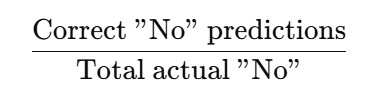


  - Correct "No" predictions = **1924**
  - Total actual "No" = **1924 + 9 = 1933**
  - Recall = **1924 / 1933 = 0.9953** (or **99.53%**)

- But in the classification report, it shows **1.00 (100%)** instead of **0.9953 (99.53%)**.

**Rounding issue** – The report might be rounding 99.53% to 100%.

**What’s the Bigger Issue Here?**  
- The model is **biased toward predicting "No"**, because "No" cases dominate the dataset.  
- It **misses many actual "Yes" cases** (defaults), as shown by the **low 28% recall for "Yes"**.  
- This makes the model **less useful for detecting defaulters**, which is likely the main goal.  

**What are the most important predictors used by the NB classifier?**

Although NB uses all the features when predicting Y, we know that not all predictors are equally important.

Unfortunately, there is not direct way to evaluate importance of each feature in NB.

But fortunately, there is an indirect way, applicable to any classification method: the permutation importance method.

From the scikit-learn documentation:

"Permutation_importance is a method used to estimate the importance of each feature in a predictive model by randomly shuffling the values of a single feature and observing the impact on the model's performance."

"Use the original trained model to make predictions on the test set with permuted features (X_test with one feature permuted at a time)."

"Compare the performance of the model on the test set with permuted features to the baseline performance."

"The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column."

"The drop in performance indicates the importance of the feature. If permuting a feature leads to a significant drop in performance, that feature is considered important."

The permutation_importance function is typically used on the test set, not the training set. This is because you want to evaluate the impact of permuting the feature values on the model's performance in predicting new, unseen data.

**5. Understanding Feature Importance in Naïve Bayes**
Unlike some models, Naïve Bayes **does not** directly tell us which features are most important. However, we can use **Permutation Importance** to estimate feature importance.

✅ **How Permutation Importance Works:**
1. Take the trained model and test it on a dataset.
2. **Randomly shuffle (permute) one feature at a time**.
3. Check how much the model’s performance drops.
4. If the model performs much worse when a feature is shuffled, that feature is important.

✅ **Real-life example:**
Imagine you’re baking a cake. If you randomly swap one ingredient (e.g., remove sugar), you check how much it affects the final cake. If the cake still turns out fine, sugar wasn’t that important. But if the cake tastes awful, sugar was a key ingredient. Similarly, in a model, **if removing a feature causes a big drop in accuracy, that feature was important**.

✅ **Why Use Permutation Importance?**
- Since Naïve Bayes assumes all features contribute equally to predictions, this method helps us **find which features actually matter most**.
- It works on **any classifier**, so it’s useful when a model doesn’t provide built-in feature importance scores.

---



**6. Next Steps to Improve the Model**
Since the model struggles with predicting "Yes" cases (defaults), consider:

**Use Permutation Importance**
   - Identify which features contribute most to predicting defaults and consider feature engineering or removal of less useful features.



### 📌 **Feature Importance Using Permutation Importance (Skip Running This Step)**

In [17]:
from sklearn.inspection import permutation_importance

In [18]:
# Estimate feature importance using permutation importance
# n_repeats represents the # of times we permute each column (each feature)
permutation_imp_results = permutation_importance(nb_classifier_default, X_test, y_test, n_repeats=10, random_state=1)

# Extract mean importance scores for each feature
# The final importance is the average obtained after each feature has been permuted 'n_repeats' times
permutation_feature_imp = permutation_imp_results.importances_mean

# Convert results into a DataFrame
permutation_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': permutation_feature_imp})

In [19]:
permutation_importance_df

,Feature,Importance
0,balance,0.01685
1,income,-0.00145
2,student_Yes,-0.00125


In [20]:
# Display sorted feature importance values
permutation_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,balance,0.01685
2,student_Yes,-0.00125
1,income,-0.00145


**🤔 Why do we do this?**
- Permutation importance helps **understand which features most affect predictions**.
- If a feature’s importance is low, it might not be useful for the model and can be removed.

✅ **Real-Life Example:**
Imagine a **retail company** 🛒 predicting customer purchases.
- **Income** might be a strong predictor of spending, while **ZIP code** might not be.
- If **ZIP code** has low importance, the company can **ignore it to simplify the model**.

---

**Interpreting the Permutation Importance Results**  

The permutation importance values tell us **which features have the biggest impact on model performance**. Here’s what the results reveal:  

| **Feature**  | **Importance Score** |
|-------------|--------------------|
| **balance**  | 0.01685  |
| **student_Yes** | -0.00125  |
| **income** | -0.00145  |

---

**What Do These Results Mean?**  
1. **Balance is the most important feature**  
   - It has the highest importance score (**0.01685**), meaning the model **relies on it the most** for making predictions.  
   - If you remove or shuffle the **balance** feature, the model’s performance drops significantly.  
   - ✅ **Real-life example:** If you were a bank deciding who to give a loan to, a person’s **bank balance** would likely be a major factor.  

2. **Income and Student Status are not important**  
   - **Income (-0.00145) and Student_Yes (-0.00125) have negative importance**, meaning they may **not be useful** for predicting loan default.  
   - If you remove these features, the model’s accuracy **stays the same or even improves slightly**.  
   - ✅ **Real-life example:** If a bank finds that **income level** doesn't help in predicting default, they may stop using it in their risk calculations.  

---

**We apply Permutation importance only for NB and KNN**

AUC and ROC curve


---

### 📌 **Compute the ROC-AUC Score & Plot the ROC Curve**

In [21]:
# Compute the Area Under the ROC Curve (AUC)
roc_auc_nb = roc_auc_score(y_test, nb_classifier_default.predict_proba(X_test)[:, 1])

In [22]:
# Area under the ROC curve, rounded to 3 decimal places
np.round (roc_auc_nb, 3)

np.float64(0.951)

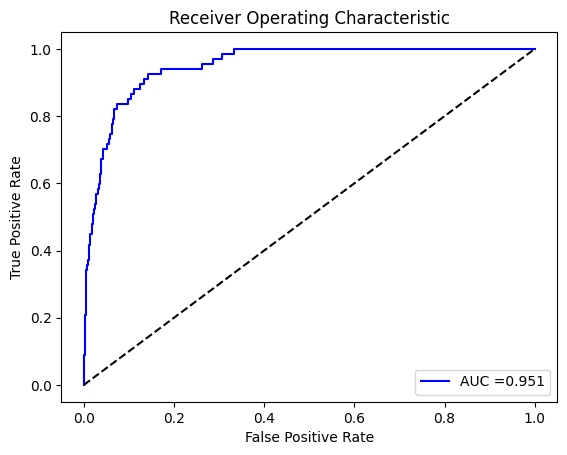

In [23]:
# Plot ROC Curve

# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and threshold values
# The ROC curve helps evaluate the classification model's performance
fpr, tpr, threshold = roc_curve(y_test, nb_classifier_default.predict_proba(X_test)[:, 1], pos_label='Yes')

# Set the title of the plot
plt.title('Receiver Operating Characteristic')

# Plot the ROC curve using FPR and TPR
# The blue line represents the ROC curve
plt.plot(fpr, tpr, 'b', label='AUC =' + str(np.round(roc_auc_nb, 3)))

# Add a legend at the lower right to display the AUC score
plt.legend(loc='lower right')

# Plot a diagonal dashed line (random classifier baseline)
plt.plot([0, 1], [0, 1], 'k--')

# Label the x-axis as 'False Positive Rate'
plt.xlabel('False Positive Rate')

# Label the y-axis as 'True Positive Rate'
plt.ylabel('True Positive Rate')

# Display the ROC curve plot
plt.show()


**🤔 Why do we do this?**
- The **ROC curve** visualizes the trade-off between true positives and false positives.
- **AUC score** (Area Under the Curve) measures how well the model distinguishes between defaulters and non-defaulters.

✅ **Real-Life Example:**
Imagine a **fraud detection model** 💳 flagging fraudulent transactions.
- **High AUC** means the model effectively separates **fraudulent vs. legitimate transactions**.
- **Low AUC** means the model **struggles to differentiate fraud from normal spending**, leading to financial risks.

---

### **Interpreting the ROC Curve and AUC Score**  

This **Receiver Operating Characteristic (ROC) curve** helps assess how well your model differentiates between **defaulters ("Yes") and non-defaulters ("No")**.

#### **Key Points About the ROC Curve:**
- The **x-axis (False Positive Rate - FPR)** represents cases where the model incorrectly predicts a **default ("Yes") when it should be "No"**.  
- The **y-axis (True Positive Rate - TPR)** represents cases where the model correctly predicts **defaults ("Yes")**.  
- The **blue line** shows your model's performance, and the closer it is to the **top-left corner**, the better the model.  
- The **diagonal dashed line** represents a random guess (AUC = 0.5), meaning a completely useless model.

#### **AUC Score (0.951) - What It Means**
- **AUC (Area Under the Curve) = 0.951** means that the model is **excellent** at distinguishing between defaulters and non-defaulters.  
- AUC values:
  - **0.5 → Random guessing (bad model).**
  - **0.7 - 0.8 → Fair model.**
  - **0.8 - 0.9 → Good model.**
  - **0.9 - 1.0 → Excellent model. ✅**  
- **Your model’s AUC (0.951) suggests that 95.1% of the time, it ranks a random defaulter higher than a random non-defaulter.**  

#### **Takeaways**
✅ **The model is excellent at differentiating between defaults and non-defaults.**  
✅ **AUC near 1.0 means high predictive power.**  
⚠️ **However, recall for defaulters ("Yes") is still low, meaning it might be missing some actual defaults.**  

***
***

# 📌 **Obtaining a classification tree for Credit Default Prediction**


---

### 📌 **Defining Hyperparameters for Grid Search**

In [34]:
# Notice that we have an extra hyperparameter here when compared to regression trees: 'criterion'.
# Therefore, I am using fewer options for each hyperparameter in comparison with regression trees to minimize comp time.

# Define a hyperparameter grid for tuning a decision tree classifier
hyperparam_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criteria
    'max_depth': np.arange(2, 7),  # Tree depths from 2 to 6
    'min_samples_split': [0.05, 0.1, 0.15, 0.2],  # Min percentage of samples needed to split a node
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],  # Min percentage of samples needed in a leaf node
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.01, 0.05]  # Minimum impurity decrease for a split
}


📌 **Why do we do this?**  
- **Hyperparameters** control how the tree is built.  
- `criterion`: Decision trees use **"gini" (Gini Index) or "entropy" (Information Gain)** to split nodes.  
- `max_depth`: Limits how **deep** the tree can grow (avoids overfitting).  
- `min_samples_split`: The **minimum % of data points** needed to create a split.  
- `min_samples_leaf`: The **minimum % of data points** needed in a leaf node.  
- `min_impurity_decrease`: A **threshold for stopping growth** if splitting doesn’t improve purity.  

✅ **Real-Life Example:**  
Think of **planting a tree**:  
- You decide **how deep the roots should go**, **how many leaves grow per branch**, and **when to stop growth**.

---

---

### 📌 **Setting Up Cross-Validation (K-Fold Method)**  

In [35]:
# Set up cross-validation with 10 splits, shuffling the data for randomness
cv_set_up = KFold(n_splits=10, shuffle=True, random_state=1)


📌 **Why do we do this?**  
- **K-Fold Cross-Validation** splits the training data into **10 smaller sets** (folds).  
- The model is trained **10 times**, each time using a different fold as the validation set.  
- Helps ensure the model is **robust** and not biased toward a particular split.  

✅ **Real-Life Example:**  
Think of **studying for an exam**:  
- Instead of reading a book **once**, you break it into **10 sections** and review each one separately to test your knowledge.

---

---

### 📌 **Performing Grid Search for Hyperparameter Tuning**  

In [36]:
# Initialize GridSearchCV for hyperparameter tuning using DecisionTreeClassifier
grid_search_setting_pre_pru = GridSearchCV(
    DecisionTreeClassifier(random_state=1),  # Base model
    param_grid=hyperparam_grid,  # Hyperparameter grid to search
    cv=cv_set_up,  # Cross-validation setup
    scoring='accuracy'  # Use accuracy as the evaluation metric
)

📌 **Why do we do this?**  
- `GridSearchCV` tries **every combination** of hyperparameters and selects the one with the **best accuracy**.  
- Uses **cross-validation (10-fold)** to make sure results are consistent.  

✅ **Real-Life Example:**  
Imagine **choosing the best phone**:  
- You test different **brands, screen sizes, camera quality, and battery life** before deciding.

---

---

### 📌 **Training the Model with Best Hyperparameters**  

In [38]:
# Fit the grid search on the training data
grid_search_setting_pre_pru.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6]),
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.01,
                                                   0.05],
                         'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
                         'min_samples_split': [0.05, 0.1, 0.15, 0.2]},
             scoring='accuracy')


📌 **Why do we do this?**  
- **Trains multiple models** with different hyperparameters.  
- Selects the **best model** based on accuracy.  

✅ **Real-Life Example:**  
Think of **baking cookies**:  
- You try different **oven temperatures, baking times, and ingredient ratios** to find the **perfect recipe**.

---

---

### 📌 **Getting the Best Hyperparameters**  

In [39]:
# Print the best hyperparameters found
print('The best hyperparameters are:', grid_search_setting_pre_pru.best_params_)

The best hyperparameters are: {'criterion': 'gini', 'max_depth': np.int64(2), 'min_impurity_decrease': 0, 'min_samples_leaf': 0.05, 'min_samples_split': 0.05}


📌 **Why do we do this?**  
- Displays the **optimal settings** found by `GridSearchCV`.  

✅ **Real-Life Example:**  
Imagine testing **multiple job interview strategies**.  
- You find that **dressing professionally, making eye contact, and practicing common questions** work best.

---

---

### 📌 **Creating a Pruned Decision Tree with the Best Parameters**  

In [40]:
# Create a DecisionTreeClassifier using the best found hyperparameters
tree_default_prepruned = DecisionTreeClassifier(
    criterion='gini',  # Best found splitting criterion
    max_depth=2,  # Best found max depth
    min_samples_split=0.05,  # Best found min samples required to split
    min_samples_leaf=0.05,  # Best found min samples required per leaf
    min_impurity_decrease=0,  # Best found min impurity decrease
    random_state=1  # Ensure reproducibility
)

📌 **Why do we do this?**  
- **Creates a decision tree** using the best hyperparameters from `GridSearchCV`.  
- **Pre-pruning** limits tree growth to **prevent overfitting**.  

✅ **Real-Life Example:**  
Imagine a **budget plan**:  
- Instead of spending money **without limits**, you set **maximum spending rules** to avoid financial trouble.

---

**Remember** that you can also retrieve the best solution by simply invoking the 'best_estimator_' attribute on the grid search object. Like this:

### 📌 **Using the Best Decision Tree Model from Grid Search**  

Instead of manually specifying hyperparameters, the best model found by `GridSearchCV` can be directly used.

---

### 📌 **Assigning the Best Model from Grid Search**


In [ ]:
# Retrieve the best decision tree model found by GridSearchCV
# tree_default_prepruned = grid_search_setting_pre_pru.best_estimator_



📌 **Why do we do this?**  
- `grid_search_setting_pre_pru.best_estimator_` automatically selects the best decision tree model from the grid search.  
- This ensures the model **has the optimal hyperparameters** found through cross-validation.  

✅ **Real-Life Example:**  
Imagine **buying a car**:  
- Instead of manually testing different models, you let a **professional reviewer** pick the best one for you.
---

### 📌 **Training and Visualizing the Decision Tree**

Now that the best hyperparameters have been found, the next step is to **train the decision tree, visualize it, and evaluate its predictions**.

---

### 📌 **Training the Decision Tree Model**

In [41]:

# Train the decision tree on the training data
tree_default_prepruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0,
                       min_samples_leaf=0.05, min_samples_split=0.05,
                       random_state=1)

📌 **Why do we do this?**  
- **Creates and trains the decision tree** using the optimal hyperparameters.  
- The tree is **pre-pruned** to prevent overfitting.  

✅ **Real-Life Example:**  
Think of training a **security guard**:  
- Instead of memorizing every criminal, they learn **rules** (e.g., "People wearing masks inside the bank are suspicious").  

---

---

### 📌 **Visualizing the Decision Tree**

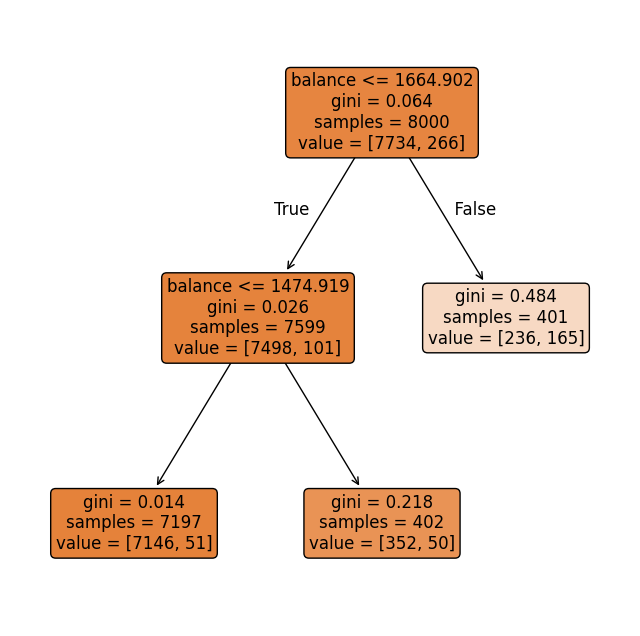

In [47]:
# Plot the decision tree
plt.figure(figsize=(8, 8))  # Set figure size
plot_tree( # Changed from tree.plot_tree to plot_tree
    tree_default_prepruned,
    filled=True,  # Fill nodes with color
    rounded=True,  # Round node edges
    feature_names=X_train.columns,  # Label nodes with feature names
    fontsize=12  # Set font size for readability
)
plt.show()  # Display the tree

📌 **Why do we do this?**  
- Displays a **tree diagram** showing how the model makes decisions.  
- `filled=True` colors nodes based on their classification.  
- `feature_names=X_train_def.columns` labels the branches with feature names.  

✅ **Real-Life Example:**  
Think of a **flowchart** for diagnosing an illness:  
- **"Do you have a fever?" → "Yes" → "Do you have a cough?"**  
- The tree follows a **step-by-step decision-making process**.


---

### 📌 **Checking the Classes Predicted by the Model**

In [50]:
# Get the class labels of the trained decision tree
tree_default_prepruned.classes_

array(['No', 'Yes'], dtype=object)

📌 **Why do we do this?**  
- Shows the **two possible output classes** (e.g., `default = Yes/No`).  

✅ **Real-Life Example:**  
Think of a **spam filter**:  
- The model classifies emails as **"Spam"** or **"Not Spam"**.  

---

---

### 📌 **Making Predictions on the Test Set**

In [51]:
# Predict labels for the test set
y_pred_pre_tree_def = tree_default_prepruned.predict(X_test)

📌 **Why do we do this?**  
- Uses the trained model to **predict** whether each test case will default or not.  

✅ **Real-Life Example:**  
Think of a **weather app**:  
- After training on past weather data, the app **predicts** if it will rain tomorrow.  

---


### 📌 **Creating the Confusion Matrix**

In [53]:
# Generate the confusion matrix to evaluate performance
confusion_matrix(y_test, y_pred_pre_tree_def)

array([[1933,    0],
       [  67,    0]])

📌 **Why do we do this?**  
- The **confusion matrix** evaluates how well the model performs.  
- It counts:
  - **True Positives (TP)**: Correctly predicted "Yes" (default).  
  - **True Negatives (TN)**: Correctly predicted "No" (no default).  
  - **False Positives (FP)**: Predicted "Yes" but the actual was "No" (False Alarm).  
  - **False Negatives (FN)**: Predicted "No" but the actual was "Yes" (Missed Default).  

✅ **Real-Life Example:**  
Think of a **fire alarm system**:  
- **TP:** Alarm rings when there’s fire.  
- **TN:** No alarm when there's no fire.  
- **FP:** False alarm when there’s no fire.  
- **FN:** No alarm when there is a fire (dangerous!).  

---

Without obtaining the classification report, tell me the specificity and sensitivity of this classifier.

---

### 📌 **Displaying the Confusion Matrix as a DataFrame**

In [54]:
# Convert the confusion matrix into a DataFrame for better readability
df_conf_mattrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred_pre_tree_def),
    index=['Actual_No', 'Actual_Yes'],  # Row labels for actual values
    columns=['Pred_No', 'Pred_Yes']  # Column labels for predicted values
)

# Display the confusion matrix DataFrame
df_conf_mattrix

,Pred_No,Pred_Yes
Actual_No,1933,0
Actual_Yes,67,0


📌 **Why do we do this?**  
- Converts the confusion matrix into a **table format** for better readability.  

✅ **Real-Life Example:**  
Think of a **store's inventory system**:  
- Instead of a list of sold items, the store uses a **sales report table** to analyze trends.

---

In [ ]:
# Specificity = Recall for 0 class ('No' class)



In [ ]:
# Sensitivity = Recall for 1 class ('Yes' class)



# **Post-pruning via CCP**


**Why do we prune a decision tree?**

A decision tree can become too complex if it keeps growing without restrictions. This is called **overfitting**, where the model memorizes the training data but performs poorly on new data. **Pruning** helps simplify the tree by removing unnecessary splits, making it more generalizable.

🎯 **Real-life Example**

Imagine a student preparing for a math exam. Instead of memorizing every single practice question, they focus on **key concepts and patterns**. This way, they can solve **new** problems using what they've learned rather than just recalling exact answers.

**Growing an Unpruned Tree**

We first create a large decision tree without any pruning.

### 📌 **Building, Pruning, and Evaluating a Decision Tree**  

Now, we are growing a **large decision tree (unpruned)** and then **applying post-pruning** to improve its performance.

---

### 📌 **Growing a Large (Unpruned) Decision Tree**  

In [56]:
# Growing a big (unpruned) decision tree using Gini criterion
tree_default_unpruned = DecisionTreeClassifier(criterion='gini', random_state=1)

# Train the unpruned decision tree
tree_default_unpruned.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

📌 **Why do we do this?**  
- **Creates a large decision tree** without restrictions (default behavior).  
- Uses **Gini Index** (`criterion='gini'`) to measure node purity.  
- This allows the model to find **all** possible patterns in the training data before we decide which splits are unnecessary.

✅ **Real-Life Example:**  
Imagine **memorizing an entire book** instead of summarizing key points.  
Imagine a student studying for an exam. Instead of filtering out unnecessary topics right away, they first go through everything and later decide what to focus on.


- The **tree grows fully** before pruning.  

---


We first create a large decision tree without any pruning.

**Finding Optimal Pruning Parameters**

We now calculate **Cost Complexity Pruning (CCP) values**, which determine how much we should prune the tree.



---

### 📌 **Getting Cost Complexity Pruning Path**  

In [57]:
# Get the cost complexity pruning path
ccp_path = tree_default_unpruned.cost_complexity_pruning_path(X_train, y_train)



📌 **Why do we do this?**  
- **Cost Complexity Pruning (CCP)** helps control overfitting.  
- Finds **alpha values** (pruning thresholds) to **simplify the tree**.  
- The ccp_alpha value controls how much pruning happens.
- Smaller values = Less pruning (complex tree).
- Larger values = More pruning (simpler tree).

✅ **Real-Life Example:**  
Imagine **trimming unnecessary details** from a long speech to keep only key points.  

Think of pruning a tree in a garden. Cutting a few small branches (low alpha) keeps it mostly intact, while trimming many branches (high alpha) makes it much smaller.

---



---

### 📌 **Extracting Possible Alpha Values for Pruning**  

In [58]:
# Extracting the possible alpha values for pruning
hyperparam_grid_alpha = {'ccp_alpha': ccp_path.ccp_alphas}

📌 **Why do we do this?**  
- Creates a **hyperparameter grid** with possible `ccp_alpha` values for pruning.  
- `ccp_alpha` **controls the trade-off** between complexity and accuracy.  

✅ **Real-Life Example:**  
Think of **removing weak players from a soccer team**:  
- Keeping only **strong performers** leads to **better efficiency**.

---

**Selecting the Best Pruning Level**

We use **Grid Search** to test different pruning levels and find the best one.

### 📌 **Using Grid Search to Find the Best Alpha for Pruning**  

In [59]:
# Perform GridSearchCV to find the best alpha value for pruning
gridSearch_alpha = GridSearchCV(
    tree_default_unpruned,
    param_grid=hyperparam_grid_alpha,
    cv=cv_set_up,  # Use cross-validation setup
    scoring='accuracy'  # Optimize for accuracy
)

# Fit the grid search on the training data
gridSearch_alpha.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'ccp_alpha': array([0.00000000e+00, 8.33333333e-05, 8.33333333e-05, 8.33333333e-05,
       8.33333333e-05, 8.33333333e-05, 8.33333333e-05, 9.37500000e-05,
       9.37500000e-05, 9.37500000e-05, 9.37500000e-05, 1.00961538e-04,
       1.04166667e-04, 1.04166667e-...
       2.00000000e-04, 2.00534759e-04, 2.02222222e-04, 2.03579060e-04,
       2.10290714e-04, 2.12279072e-04, 2.13366053e-04, 2.13876441e-04,
       2.14285714e-04, 2.19047619e-04, 2.23958333e-04, 2.26200459e-04,
       2.29379529e-04, 2.38769436e-04, 2.51343221e-04, 2.51906499e-04,
       3.01985371e-04, 3.09205260e-04, 3.71320978e-04, 6.61055035e-04,
       1.46402135e-03, 2.67487516e-03, 1.63630910e-02])},
             scoring='accuracy')

📌 **Why do we do this?**  
- **Searches for the best `ccp_alpha` value** using cross-validation.  
- Ensures the tree is **not too deep (overfit) or too shallow (underfit)**.  

✅ **Real-Life Example:**  
Think of **finding the perfect water level** when brewing coffee.  
- **Too much water = diluted flavor** (underfitting).  
- **Too little water = overly concentrated** (overfitting).  

---

### 📌 **Getting the Best Pruning Parameter**  

In [60]:
# Print the best alpha parameter found
print('The best parameters are:', gridSearch_alpha.best_params_)

The best parameters are: {'ccp_alpha': np.float64(0.0003713209784991789)}


📌 **Why do we do this?**  
- Prints the **best `ccp_alpha` value** found using `GridSearchCV`.  

✅ **Real-Life Example:**  
Think of a **budget plan**:  
- Finding the **right balance** between spending and saving.

---

### 📌 **Training the Pruned Decision Tree**  

In [62]:
# Train a post-pruned decision tree using the best alpha value
tree_default_postpruned = DecisionTreeClassifier(
    random_state=1,
    ccp_alpha=gridSearch_alpha.best_params_['ccp_alpha']  # Apply best alpha for pruning
)

# Fit the pruned decision tree on the training data
tree_default_postpruned.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=np.float64(0.0003713209784991789),
                       random_state=1)


📌 **Why do we do this?**  
- Creates a **pruned decision tree** using the best `ccp_alpha` found.  
- Removes **unnecessary branches** to improve **generalization**.  

✅ **Real-Life Example:**  
Think of **editing a resume**:  
- **Removing extra details** makes it **easier to read and more effective**.

---

### 📌 **Visualizing the Pruned Decision Tree**  

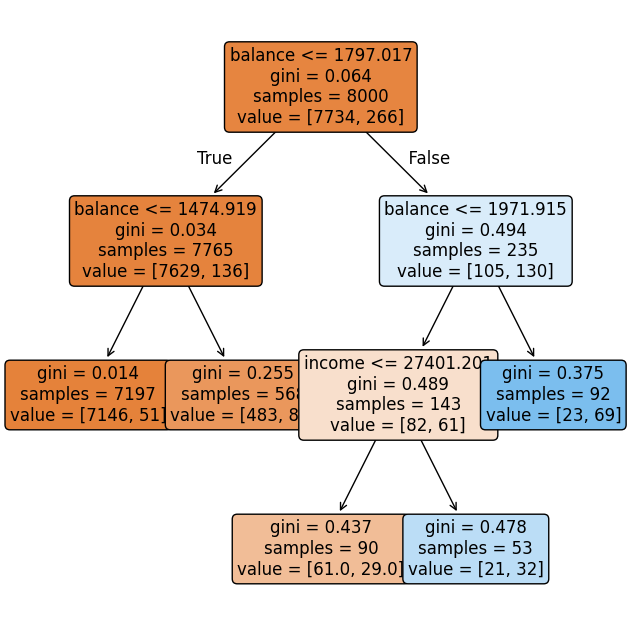

In [63]:
# Plot the decision tree
plt.figure(figsize=(8, 8))  # Set figure size
plot_tree( # Changed from tree.plot_tree to plot_tree
    tree_default_postpruned,
    filled=True,  # Fill nodes with color
    rounded=True,  # Round node edges
    feature_names=X_train.columns,  # Label nodes with feature names
    fontsize=12  # Set font size for readability
)
plt.show()  # Display the tree

📌 **Why do we do this?**  
- Displays the **simplified tree structure** after pruning.  
- Nodes with **less importance** are removed.  

✅ **Real-Life Example:**  
Think of **pruning a bonsai tree**:  
- **Trimming unnecessary branches** makes it **look better and grow healthier**.

---

### **Simple Summary of Decision Tree Analysis**

1. **How the Tree Works**  
   - The left side of the tree (balance ≤ 1797) is **very clear and confident** in classification.  
   - The right side (balance > 1797) is **more uncertain**, needing extra splits to make decisions.

2. **How Pure the Splits Are (Gini Score)**  
   - **Low Gini (close to 0) = good split** (most samples clearly belong to one group).  
   - **High Gini (closer to 0.5) = mixed results** (less clear decision-making).  
   - Example: The left-most group is almost all one class (**very confident**), while the right-most group is much more mixed (**less certain**).

3. **What Matters Most**  
   - **Balance is the biggest deciding factor** in the tree—it influences the first major split.  
   - **Income matters, but only in trickier cases**, deeper in the tree.

4. **Uneven Data (Class Imbalance)**  
   - Most of the data falls into one category (7734 vs. 266), so the tree is **better at classifying the majority** and struggles with the smaller group.

5. **How Confident the Tree Is**  
   - **Most cases are decided early**, meaning deeper splits aren't always needed.  
   - The **right side is messier**, with more uncertainty and smaller sample sizes.

---

### **Final Thoughts**  
- The model does well for most cases, especially on the left side.  
- Some parts (especially on the right) need more information to improve accuracy.  
- **Balance is the key feature**, while income helps in complicated cases.  
- **Fixing the class imbalance** could make the tree more reliable.





### 📌 **Making Predictions with the Pruned Tree**

In [64]:
# Predict labels for the test set using the pruned tree
y_pred_post_pr_tree_def = tree_default_postpruned.predict(X_test)

📌 **Why do we do this?**  
- Uses the **pruned decision tree** to **predict outcomes** on test data.  

✅ **Real-Life Example:**  
A **simplified decision-making process** is faster and more efficient.  

---


### 📌 **Creating a Confusion Matrix to Evaluate Model Performance**  

In [65]:
# Generate the confusion matrix to evaluate model performance
confusion_matrix(y_test, y_pred_post_pr_tree_def)

array([[1920,   13],
       [  37,   30]])

📌 **Why do we do this?**  
- Evaluates how well the pruned model **classifies default cases**.  

✅ **Real-Life Example:**  
Think of a **medical test**:  
- A good test **correctly identifies sick and healthy patients**.

---


In [66]:
# Convert the confusion matrix into a DataFrame for better readability
conf_mattrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred_post_pr_tree_def),
    index=['Actual_No', 'Actual_Yes'],  # Row labels for actual values
    columns=['Pred_No', 'Pred_Yes']  # Column labels for predicted values
)

# Display the confusion matrix DataFrame
conf_mattrix

,Pred_No,Pred_Yes
Actual_No,1920,13
Actual_Yes,37,30


### 📌 **Generating a Classification Report for Model Evaluation**

In [67]:
# Print the classification report for detailed evaluation
print(classification_report(y_test, y_pred_post_pr_tree_def))

              precision    recall  f1-score   support

          No       0.98      0.99      0.99      1933
         Yes       0.70      0.45      0.55        67

    accuracy                           0.97      2000
   macro avg       0.84      0.72      0.77      2000
weighted avg       0.97      0.97      0.97      2000



📌 **Why do we do this?**  
- Provides key metrics:  
  - **Precision** (How many predicted defaults were actually correct?)  
  - **Recall** (Did we find all actual defaults?)  
  - **F1-score** (Balance between precision and recall)  
  - **Accuracy** (Overall correctness of predictions)  

✅ **Real-Life Example:**  
Think of **grading an exam**:  
- **Accuracy** tells how many answers were correct.  
- **Precision** checks if students got tricky questions right.  
- **Recall** checks if we identified all weak students needing help.  

---

__What are the most important predictors?__

What predictors show up in the tree?

### 📌 **Feature Importance and Model Performance Evaluation**  

Now, we are analyzing **which features contribute the most** to predictions and evaluating the **ROC-AUC score** for the pruned decision tree.

---

### 📌 **Identifying Important Features**  

In [68]:
# Get the names of features with non-zero importance
X_train.columns[tree_default_postpruned.feature_importances_ != 0]

Index(['balance', 'income'], dtype='object')

📌 **Why do we do this?**  
- Extracts **only the features** that the pruned decision tree considers important (i.e., features with nonzero importance).  

✅ **Real-Life Example:**  
Think of **hiring an employee**:  
- Some skills matter more than others. This helps us see **which skills influence the hiring decision**.

---


What is the importance of each predictor?

### 📌 **Creating a Feature Importance DataFrame**  

In [69]:
# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_default_postpruned.feature_importances_
})


📌 **Why do we do this?**  
- Stores **feature importance scores** in a DataFrame.  
- Helps understand which variables contribute the most to predictions.  

✅ **Real-Life Example:**  
A **restaurant ranking system** might value **food quality (70%)** more than **wait time (30%)**.  
- This helps focus on **what really matters**.

---

### 📌 **Sorting Features by Importance**  

In [70]:
# Sort features by importance in descending order
importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,balance,0.968764
1,income,0.031236
2,student_Yes,0.000000


📌 **Why do we do this?**  
- Displays **features in descending order of importance**.  

✅ **Real-Life Example:**  
Think of **prioritizing college courses**:  
- **"Math (High Importance), Gym (Low Importance)"** helps decide where to focus.

---

Obtain the ROC curve and AUC.

### 📌 **Calculating the ROC-AUC Score**  

In [71]:

# Compute the ROC-AUC score for the pruned decision tree
roc_auc_postpruned = roc_auc_score(y_test, tree_default_postpruned.predict_proba(X_test)[:, 1])


📌 **Why do we do this?**  
- **ROC-AUC measures the model's ability to distinguish between classes.**  
- The closer **AUC is to 1**, the better the model at separating defaults from non-defaults.  

✅ **Real-Life Example:**  
Think of **a doctor diagnosing a disease**:  
- A **perfect test (AUC=1.0) correctly identifies all sick and healthy patients**.  

---

### 📌 **Rounding and Printing the ROC-AUC Score**

In [72]:
# Round and print the ROC-AUC score
np.round(roc_auc_postpruned, 3)

np.float64(0.875)

### 📌 **Plotting the ROC Curve**  

In [73]:
# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds foe ROC curve
fpr, tpr, threshold = roc_curve(y_test, tree_default_postpruned.predict_proba(X_test)[:, 1], pos_label='Yes')


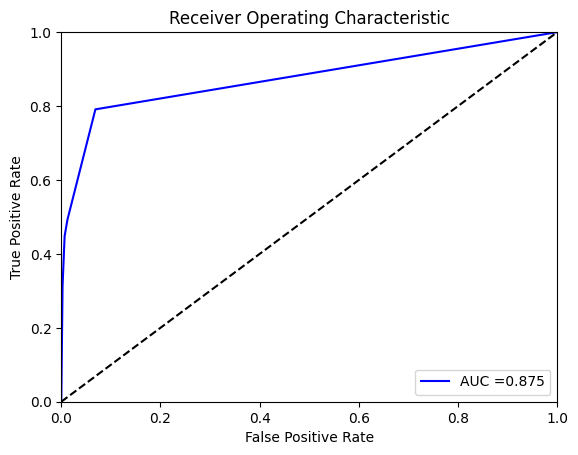

In [74]:
# Plot the ROC curve
plt.title('Receiver Operating Characteristic')  # Set plot title
plt.plot(fpr, tpr, 'b', label='AUC =' + str(np.round(roc_auc_postpruned, 3)))  # Plot ROC curve with AUC label
plt.legend(loc='lower right')  # Set legend position
plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal reference line
plt.xlim([0, 1])  # Set x-axis limits
plt.ylim([0, 1])  # Set y-axis limits
plt.ylabel('True Positive Rate')  # Label y-axis
plt.xlabel('False Positive Rate')  # Label x-axis
plt.show()  # Display the plot


📌 **Why do we do this?**  
- **Visualizes model performance.**  
- The **closer the blue curve is to the top-left**, the better the model.  

✅ **Real-Life Example:**  
Think of a **spam filter**:  
- **High TPR (True Positive Rate)** → Correctly detects spam emails.  
- **Low FPR (False Positive Rate)** → Doesn't wrongly classify important emails as spam.  

---

Compare the performance of NB and the post-pruned tree based on AUC:

NB results:

AUC= 0.951


The NB classifier gives a better balance between sensitivity and specificity across multiple probability thresholds (because it has a higher AUC).

---

# 📌 **Random Forests. Selection based on accuracy for Credit Default Prediction**


### 📌 **Define Hyperparameter Grid for Random Forest**

In [77]:
# Define hyperparameter grid
number_of_trees_rf = np.array([500, 750, 1000])  # Different number of trees
number_of_features = np.array([1, 2, 3])  # Number of features considered per split
criterion_options = ['entropy', 'gini']  # Splitting criteria

class_weight_options = ['balanced', None]

hyperparam_grid_rf = {
    'criterion': criterion_options,
    'n_estimators': number_of_trees_rf,
    'max_features': number_of_features,
    'class_weight': class_weight_options
}



🤔 **Why do we do this?**
- **More trees = Better accuracy but longer training time**.
- **Entropy vs. Gini**: Measures how well splits improve classification.
- **Handling class imbalance**: Important for datasets where one class dominates.

✅ **Real-Life Example:**  
A **bank wants to improve churn prediction accuracy**.  
- By testing **different model configurations**, they find the **best-performing settings**.

---

### 📌 **Perform Grid Search to Find Best Hyperparameters**

In [81]:
# Use 3-fold cross-validation (not 10!)
from sklearn.ensemble import RandomForestClassifier # import the RandomForestClassifier class from sklearn.ensemble

# cv_object = KFold(n_splits=3, shuffle=True, random_state=1) already called above

# Grid search to find the best hyperparameters
grid_search_setting_rf = GridSearchCV(
    RandomForestClassifier(random_state=1),
    hyperparam_grid_rf,
    cv=cv_object,
    scoring='accuracy'
)

grid_search_setting_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['entropy', 'gini'],
                         'max_features': array([1, 2, 3]),
                         'n_estimators': array([ 500,  750, 1000])},
             scoring='accuracy')

In [82]:
# Print best parameters
print('Best Parameters:', grid_search_setting_rf.best_params_)

Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_features': np.int64(1), 'n_estimators': np.int64(500)}


🤔 **Why do we do this?**
- **Grid Search** tests multiple hyperparameter combinations.
- **Cross-validation (3-fold)** ensures **stable results** by training the model on different subsets.
- The best **combination of parameters** improves accuracy.

✅ **Real-Life Example:**  
Imagine testing **different coffee recipes** ☕:
- You try different amounts of sugar, milk, and coffee.
- After multiple tastings, you pick the **best combination**.

---

**class_weight_options = ['balanced', None]**

**What does this mean?**  

It shows the two possible values for `class_weight` when training a machine learning model:  

1. **'balanced'** – The model automatically adjusts weights based on how often each class appears. If a class is rare, it gets more importance to prevent the model from ignoring it.  
   - **Example:** If only 10% of orders are vegan pizzas, the model will **pay extra attention** to them so they don’t get overlooked.  

2. **None** – No special weights are assigned; all classes are treated equally.  
   - **Example:** If you tell your pizza shop staff to treat all orders the same, they might ignore the rare vegan pizzas and focus only on the most common orders.  

By setting `class_weight='balanced'`, you're **making sure the model doesn’t ignore rare cases**, just like how you’d tell your staff to be extra careful with the less common orders.

Imagine you’re running a **pizza shop**, and you get two types of orders:  

1. **Pepperoni Pizza** - 90% of orders  
2. **Vegan Pizza** - 10% of orders  

Since most customers order pepperoni, your staff gets really good at making it. But because vegan pizzas are rare, they often mess them up or forget about them.  

To fix this, you **tell your staff**:  
🚨 **"Pay extra attention to vegan pizzas! Mistakes on those are a big deal!"** 🚨  

Now, they take more care when making vegan pizzas, even though they’re less common.  

**In machine learning**, class_weight does the same thing—it tells the model:  
🛑 "Don’t ignore the rare cases! They matter too!"  

This helps the model learn better and not just focus on the most common category.

From the scikit-learn documentation:

__class_weight__

Weights associated with classes in the form {class_label: weight}. If not given (None option), all classes are supposed to have weight one.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as
n_samples / (n_classes * np.bincount(y)).

The option "balanced" balances the importance of a class inversely proportional to its frequency (i.e., the least frequent class gets a higher weight = more importance).

__How does changing the class weights influence the classifier?__

"The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class."

"It penalizes mistakes in samples of class[i] with class_weight[i]. So higher class-weight means you want to put more emphasis on a class."

DO NOT RUN THE FOLLOWING CODE CELL !!!!!

JUST OBSERVED THE RESULTS !!!!

### 📌 **Train the Best Random Forest Model**

In [84]:
# Train the best Random Forest model
rf_default = RandomForestClassifier(
    n_estimators=500,  # Best from Grid Search
    class_weight=None,
    criterion='gini',
    max_features=1,
    random_state=1
)

rf_default.fit(X_train, y_train)

RandomForestClassifier(max_features=1, n_estimators=500, random_state=1)

🤔 **Why do we do this?**
- After selecting the best hyperparameters, we **train the final Random Forest model**.

✅ **Real-Life Example:**  
A **school** selects the best teaching method after testing different strategies.  
Once they find the best approach, they **apply it to all students**.

### 📌 **Make Predictions with the Trained Model**

In [85]:
# Predict using the trained model ///We invoke the default threshold of 0.5 % when we use "predict"
y_pred_def_rf = rf_default.predict(X_test)

🤔 **Why do we do this?**
- After training, we **test the model** on unseen data.

✅ **Real-Life Example:**  
A **doctor diagnoses a new patient** using past knowledge from training.

---

### 📌 **Evaluate the Model Using Confusion Matrix & Classification Report**

In [86]:
# Generate confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def_rf))

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred_def_rf))

Confusion Matrix:
 [[1917   16]
 [  43   24]]
Classification Report:
               precision    recall  f1-score   support

          No       0.98      0.99      0.98      1933
         Yes       0.60      0.36      0.45        67

    accuracy                           0.97      2000
   macro avg       0.79      0.67      0.72      2000
weighted avg       0.97      0.97      0.97      2000



🤔 **Why do we do this?**
- The **confusion matrix** shows how many predictions were correct vs. incorrect.
- The **classification report** provides:
  - **Precision**: How many predicted defaulters were actually correct?
  - **Recall**: How many actual defaulters were detected?
  - **F1-score**: A balance of precision and recall.

✅ **Real-Life Example:**  
Imagine a **fire alarm system** 🔥:
- **Precision**: Of all times the alarm rang, how many were actual fires?
- **Recall**: Of all fires, how many were detected?

---

### **Model Evaluation Insights**  

Your model is predicting **"Yes"** or **"No"**, but the results still show some key issues:  

#### **Confusion Matrix Overview**  
- **1,917 correct "No" predictions** (✅ Very accurate)  
- **16 incorrect "Yes" predictions** (⚠️ Minor false positives)  
- **43 missed "Yes" cases** (❌ Model still struggles with detecting "Yes")  
- **24 correct "Yes" predictions** (✅ Slight improvement, but still low)  

#### **Performance Metrics**  
- **Precision:** "No" = 98%, "Yes" = 60% (Slightly better than before)  
- **Recall:** "No" = 99%, "Yes" = 36% (Still weak, missing most "Yes" cases)  
- **Accuracy:** 97% (Good overall, but still misleading due to imbalance)  
- **Macro Avg:** 79% (Better than before, but "Yes" needs improvement)  

### **Key Takeaways**  
1. The model **still favors "No" heavily** and struggles with "Yes."  
2. **Recall for "Yes" is low (36%)**, meaning many actual "Yes" cases are missed.  
3. **Slight improvement** in precision (60%), but still needs work to detect "Yes" cases properly.  

Each feature's importance across the trees of the forest

### 📌 **Analyze Feature Importance in the Random Forest Model**

In [88]:
# Get feature importance scores
df_feature_imp_rf = pd.Series(data=rf_default.feature_importances_, index=X_train.columns, name="Feature Importance")

# Sort by importance
df_feature_imp_rf.sort_values(ascending=False)

,Feature Importance
balance,0.660856
income,0.334726
student_Yes,0.004418


🤔 **Why do we do this?**
- **Feature importance** shows which factors matter most in predictions.
- Helps us **understand the model's decision-making**.

✅ **Real-Life Example:**  
A **bank** analyzes which factors **most influence loan defaults**:
- **Income, credit score, and debt** may be more important than **age**.

---

# 📌 **Random Forests. Selection based on the f1-score for the Yes class**


### Random Forests. Selection based on the f1-score for the Yes class.

In [89]:
from sklearn.metrics import f1_score, make_scorer

### 📌 **Optimize the Model Using F1 Score**

In [90]:
# Define F1-score optimization
my_f1_scorer = make_scorer(f1_score, pos_label='Yes')

🤔 **Why do we do this?**
- **Accuracy is misleading for imbalanced datasets**.
- **F1-score ensures a good balance between precision and recall**.

✅ **Real-Life Example:**  
A **cancer detection test** must:
- **Identify all real cases (recall)**.
- **Minimize false positives (precision)**.

---

### 📌 **Perform Grid Search to Find Best Hyperparameters**

In [92]:
# Grid search using F1-score
grid_search_setting_rf_f1score = GridSearchCV(
    RandomForestClassifier(random_state=1),
    hyperparam_grid_rf,
    cv=cv_object,
    scoring=my_f1_scorer
)

grid_search_setting_rf_f1score.fit(X_train, y_train)

# Print best parameters
print('Best Parameters (RF - F1):', grid_search_setting_rf_f1score.best_params_)

Best Parameters (RF - F1): {'class_weight': None, 'criterion': 'entropy', 'max_features': np.int64(3), 'n_estimators': np.int64(1000)}



🤔 **Why do we do this?**
- **Grid search finds the best model parameters**.
- **Cross-validation ensures reliable results**.

✅ **Real-Life Example:**  
A **bank tests different fraud detection models** and picks **the one with the best F1-score**.

---

DO NOT RUN THE FOLLOWING CODE CELL !!!!!

JUST OBSERVED THE RESULTS !!!!

### 📌 **Train the Best Random Forest Model**

In [93]:
# Train Random Forest model using the best F1-score parameters
rf_default_f1_score = RandomForestClassifier(
    class_weight=None,
    criterion='entropy',
    max_features=3,
    n_estimators=1000,
    random_state=1
)

rf_default_f1_score.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=1000,
                       random_state=1)


🤔 **Why do we do this?**
- **We train the final model using the best hyperparameters from Grid Search**.

✅ **Real-Life Example:**  
A **hospital** selects the **best diagnostic test** after testing different options.

---

### 📌 **Evaluate the Model**

In [94]:
# Generate predictions
y_pred_def_rf_f1_score = rf_default_f1_score.predict(X_test)

🤔 **Why do we do this?**
- **The model is now tested on unseen data**.
- Helps evaluate **how well it generalizes**.

✅ **Real-Life Example:**  
A **bank's fraud detection system** is **tested on real transactions**.

---

In [95]:
# Generate confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def_rf_f1_score))

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred_def_rf_f1_score))

Confusion Matrix:
 [[1915   18]
 [  43   24]]
Classification Report:
               precision    recall  f1-score   support

          No       0.98      0.99      0.98      1933
         Yes       0.57      0.36      0.44        67

    accuracy                           0.97      2000
   macro avg       0.77      0.67      0.71      2000
weighted avg       0.96      0.97      0.97      2000



🤔 **Why do we do this?**
- The **confusion matrix** shows:
  - **True Positives (TP)**: Correctly identified churned customers.
  - **False Positives (FP)**: Customers wrongly classified as churned.
  - **True Negatives (TN)**: Correctly identified retained customers.
  - **False Negatives (FN)**: Churned customers wrongly classified as retained.
- The **classification report** provides:
  - **Precision**: Out of all predicted churn cases, how many were correct?
  - **Recall**: Out of all actual churn cases, how many were detected?
  - **F1-score**: A balance of precision and recall.

✅ **Real-Life Example:**  
A **fire alarm system**:
- **Precision**: How many times the alarm rang for a real fire?
- **Recall**: How many actual fires were detected?

---

### Boosting (= Boosted Classification Trees). Selection based on accuracy.

# 📌 **Boosting (= Boosted Classification Trees). Selection based on accuracy**


### 📌 **Train Gradient Boosting Model with Grid Search**

In [98]:
# Define hyperparameter grid for Boosting
number_of_trees_boosting = np.array([100, 250, 500])  # Number of trees
lambda_values = np.array([0.001, 0.01, 0.1, 1])  # Learning rate
depth_values = np.array([2, 3, 4])  # Tree depth

hyperparam_grid_boosting = {
    'n_estimators': number_of_trees_boosting,
    'max_depth': depth_values,
    'learning_rate': lambda_values
}

🤔 **Why do we do this?**
- **More trees = More learning but longer training time**.
- **Learning rate** determines how much each tree corrects mistakes.
- **Depth** controls how complex each tree is.

✅ **Real-Life Example:**  
A **student preparing for an exam**:
- If they **study gradually (low learning rate)**, they **retain information better**.
- If they **cram quickly (high learning rate)**, they might **memorize but not understand**.

---

There is no 'class_weight" hyperparameter in boosting.

DO NOT RUN THE FOLLOWING CODE CELL !!!!!

JUST OBSERVED THE RESULTS !!!!

### 📌 **Perform Grid Search to Find Best Hyperparameters**

In [100]:
# Import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier # Import the GradientBoostingClassifier

In [101]:
# Grid search for boosting
grid_search_setting_boosting = GridSearchCV(
    GradientBoostingClassifier(random_state=1),
    hyperparam_grid_boosting,
    cv=cv_object,
    scoring='accuracy'
)

grid_search_setting_boosting.fit(X_train, y_train)

# Print best parameters
print('Best Parameters (Boosting):', grid_search_setting_boosting.best_params_)

Best Parameters (Boosting): {'learning_rate': np.float64(0.01), 'max_depth': np.int64(3), 'n_estimators': np.int64(250)}


🤔 **Why do we do this?**
- **Grid search tests multiple hyperparameter combinations**.
- **Cross-validation ensures the model is stable and not overfitting**.

✅ **Real-Life Example:**  
A **chef experiments with different ingredient combinations** and **picks the best recipe**.

---

### 📌 **Train the Best Gradient Boosting Model**

In [102]:
# Train Gradient Boosting model using best parameters
boosting_default = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=250,
    random_state=1
)

boosting_default.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=250, random_state=1)

🤔 **Why do we do this?**
- **We use the best hyperparameters from Grid Search**.
- **Gradient Boosting corrects errors and improves performance over time**.

✅ **Real-Life Example:**  
A **student who learns from past mistakes** improves with **each study session**.

---

### 📌 **Evaluate Both Models**

In [103]:
# Generate predictions
y_pred_def_boosting = boosting_default.predict(X_test)

In [104]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def_boosting))

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred_def_boosting))

Confusion Matrix:
 [[1922   11]
 [  42   25]]
Classification Report:
               precision    recall  f1-score   support

          No       0.98      0.99      0.99      1933
         Yes       0.69      0.37      0.49        67

    accuracy                           0.97      2000
   macro avg       0.84      0.68      0.74      2000
weighted avg       0.97      0.97      0.97      2000



🤔 **Why do we do this?**
- **We test the trained model on new data**.
- Helps us **check if the model generalizes well**.

✅ **Real-Life Example:**  
A **bank tests a new fraud detection system** using **real transactions**.

---


- **The confusion matrix shows**:
  - **True Positives (TP)**: Correctly predicted churned customers.
  - **False Positives (FP)**: Non-churn customers incorrectly classified as churn.
  - **True Negatives (TN)**: Correctly predicted retained customers.
  - **False Negatives (FN)**: Churned customers incorrectly classified as retained.
- **The classification report provides**:
  - **Precision**: Out of all predicted churn cases, how many were correct?
  - **Recall**: Out of all actual churn cases, how many were detected?
  - **F1-score**: A balance of precision and recall.

✅ **Real-Life Example:**  
A **fire alarm system**:
- **Precision**: How many times the alarm rang for a real fire?
- **Recall**: How many actual fires were detected?

---

When you apply Boosting, you can retrive each feature importance using almost exactly the same code you used to get the importances in Random Forests. Explore independenly !!!

# 📌 **Boosting (= Boosted Classification Trees). Selection based on the f1-score for the Yes class**


### 📌 **Perform Grid Search to Find Best Hyperparameters**

In [105]:
# Grid search using F1-score
grid_search_setting_boosting_f1score = GridSearchCV(
    GradientBoostingClassifier(random_state=1),
    hyperparam_grid_boosting,
    cv=cv_object,
    scoring=my_f1_scorer
)

DO NOT RUN THE FOLLOWING CODE CELL !!!!!

JUST OBSERVED THE RESULTS !!!!

In [106]:
grid_search_setting_boosting_f1score.fit(X_train, y_train)

# Print best parameters
print('Best Parameters (Boosting - F1):', grid_search_setting_boosting_f1score.best_params_)

Best Parameters (Boosting - F1): {'learning_rate': np.float64(0.01), 'max_depth': np.int64(4), 'n_estimators': np.int64(500)}



🤔 **Why do we do this?**
- **Accuracy is misleading when one class dominates**.
- **F1-score ensures a good balance between detecting real cases and avoiding false positives**.

✅ **Real-Life Example:**  
A **fraud detection system** must:
- **Identify all real fraud cases (recall)**.
- **Minimize false alarms (precision)**.

---


### 📌 **Train the Best Gradient Boosting Model**

In [107]:
# Train Gradient Boosting model using best F1-score parameters
boosting_default_f1_score = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=4,
    n_estimators=500,
    random_state=1
)

boosting_default_f1_score.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500,
                           random_state=1)

🤔 **Why do we do this?**
- **We use the best hyperparameters from Grid Search**.
- **Gradient Boosting corrects errors and improves performance over time**.

✅ **Real-Life Example:**  
A **student who learns from past mistakes** improves with **each study session**.

---

In [108]:
# Generate predictions
y_pred_def_boosting_f1 = boosting_default_f1_score.predict(X_test)

🤔 **Why do we do this?**
- **We test the trained model on new data**.
- Helps us **check if the model generalizes well**.

✅ **Real-Life Example:**  
A **bank tests a new fraud detection system** using **real transactions**.

---

### 📌 **Evaluate Both Models**


In [109]:
# Generate confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def_boosting_f1))

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred_def_boosting_f1))

Confusion Matrix:
 [[1920   13]
 [  44   23]]
Classification Report:
               precision    recall  f1-score   support

          No       0.98      0.99      0.99      1933
         Yes       0.64      0.34      0.45        67

    accuracy                           0.97      2000
   macro avg       0.81      0.67      0.72      2000
weighted avg       0.97      0.97      0.97      2000



In [111]:
# Print accuracy and F1-score for comparison
accuracy_boosting = (y_pred_def_boosting == y_test).mean()
# Change pos_label to 'Yes' to match the actual label in y_test
f1_boosting = f1_score(y_test, y_pred_def_boosting, pos_label='Yes')

print("Model Accuracy:", accuracy_boosting)
print("Model F1 Score:", f1_boosting)

Model Accuracy: 0.9735
Model F1 Score: 0.4854368932038835


***
***

# 📌 **Explaining LogisticRegression**

#### **What is Logistic Regression?**  
Think of **logistic regression** like a decision-making tool. It helps a model **predict between two choices**, like:  
- **"Spam" vs. "Not Spam"** for emails  
- **"Approve Loan" vs. "Deny Loan"** for banks  
- **"Has Disease" vs. "No Disease"** for medical tests  

Instead of making a hard yes/no choice right away, logistic regression **assigns probabilities** and then makes a decision. For example:  
- **An email has a 90% chance of being spam → Mark it as spam**  
- **A customer has a 20% chance of defaulting on a loan → Approve the loan**  

---

### **Key Hyperparameters in Logistic Regression (Think of these as Settings on a Machine)**  

#### **1. Regularization (Prevents Overfitting – Like Controlling Sugar in a Recipe)**  
🔹 **What is it?**  
Regularization stops the model from learning "too much" from the data (like memorizing instead of understanding). It keeps things general, so the model can work well on new data.  

🔹 **Real-life example:**  
Imagine baking cookies 🍪. If you **add too much sugar**, they might taste great to some people but **too sweet for others**. If you add **too little sugar**, they might be bland. Regularization is like **controlling the sugar level** so the cookies are balanced for everyone.  

🔹 **Types of Regularization:**  
- **L1 (Lasso)** → Shrinks some values down to **zero** (helps pick the most important features).  
- **L2 (Ridge)** → Makes all features **smaller but keeps them** (reduces extreme values).  
- **Elastic Net (L1 + L2)** → A mix of both.  

---

#### **2. Regularization Strength (C in Scikit-learn – Like a Volume Knob 🎛️)**  
🔹 **What is it?**  
This controls **how much regularization** is applied.  

🔹 **Real-life example:**  
Think of adjusting **headphone volume 🎧**:  
- **Too high** → You hear too much detail (overfitting).  
- **Too low** → You miss important sounds (underfitting).  

**C in Scikit-learn:**  
- **Big C (Low Regularization)** → Model can learn **a lot of details**, even the noise.  
- **Small C (High Regularization)** → Model focuses **only on the main patterns** and ignores noise.  

---

#### **3. Solver (Like Different Ways to Solve a Puzzle 🧩)**  
🔹 **What is it?**  
A solver is the **method used to find the best fit for the model**. Scikit-learn has multiple solvers, but the default is **'lbfgs'**.  

🔹 **Real-life example:**  
Imagine you have a **jigsaw puzzle 🧩**. You can:  
- Solve it by **starting with the edges** (faster but not always best).  
- Solve it by **sorting by colors** (slower but might give better results).  
Different solvers **use different strategies** to get the best result.  

---

#### **4. Class Weight (Handling Imbalanced Data – Like Giving Equal Attention to Everyone in a Class 📚)**  
🔹 **What is it?**  
If one class (e.g., "Spam") appears way more often than another ("Not Spam"), the model might **ignore the smaller class**. **Class weight balances this out.**  

🔹 **Real-life example:**  
Imagine a **teacher in a classroom**. If there are 90 boys and 10 girls, and the teacher **only listens to the majority**, the girls might be ignored. **Class weight ensures everyone gets equal attention.**  

- **`class_weight=None`** → Treats all classes equally.  
- **`class_weight='balanced'`** → Gives more importance to the smaller class automatically.  

---

### **Why Standardization? (Making Everything Fair – Like Converting Height to the Same Unit 📏)**  
🔹 **What is it?**  
Standardization makes sure all numbers are in the **same scale**, so no feature dominates the model.  

🔹 **Real-life example:**  
Imagine you’re comparing:  
- **Height (measured in centimeters)**  
- **Weight (measured in kilograms)**  
If you don’t standardize, the **bigger numbers (height) will dominate the model**, even if weight is equally important.  

🔹 **Solution:**  
Standardization transforms numbers so they have **a mean of 0 and standard deviation of 1**.  

🔹 **How do we do this?**  
- Use **`StandardScaler()`** to scale the numbers properly.  
- Use a **Pipeline** to apply scaling **only to numerical features** while keeping categorical features unchanged.  

---

### **Final Takeaway**  
Logistic regression is a powerful tool for **binary classification problems**. But tuning its settings (hyperparameters) **is like adjusting a recipe to get the best taste**:  

- **Regularization (L1/L2)** prevents overfitting.  
- **Regularization strength (C)** controls how much detail the model learns.  
- **Solver** determines how the model finds the best solution.  
- **Class weight** makes sure all classes get fair attention.  
- **Standardization** ensures fair comparison of different-sized numbers.  

---


# 📌 **Logistic Regression applied to the Credit Default Prediction**


### 🔍 **Import Necessary Libraries**

In [112]:
from sklearn.pipeline import Pipeline  # For building ML pipelines
from sklearn.preprocessing import StandardScaler  # For standardizing numeric features
from sklearn.compose import ColumnTransformer  # To apply transformations to specific column types
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.model_selection import GridSearchCV, KFold  # For hyperparameter tuning and cross-validation

### 📌 **Introduction**

This notebook continues the application of **Logistic Regression**, focusing on:
1. **Building a complete pipeline** for standardization and modeling.
2. **Tuning hyperparameters using Grid Search with Cross-Validation (CV)**.
3. **Understanding the impact of regularization strength and class imbalance handling**.

---

### 📌 **Define Feature Lists for Transformation**

In [113]:
# Get all column names except for the dummy variable 'student_Yes'
quantitative_features_list = X_train.columns.difference(['student_Yes'])

# Display quantitative features
quantitative_features_list

# List containing the dummy variable (already binary)
dummy_features_list = ['student_Yes']


🤔 **Why do we do this?**
- To **separate features that need to be standardized** from those that don’t.
- Dummy variables (already 0/1) should be left untouched.

✅ **Real-Life Example:**  
A bank's model should **scale income and balance**, but not **student status**, which is already a binary label.

---

### 📌 **Set Up Column Transformer for Preprocessing**

In [114]:
# Define how preprocessing should be applied to each group of features
preprocessor_default = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quantitative_features_list),  # Standardize numeric features
        ('cat', 'passthrough', dummy_features_list)             # Leave dummy feature as-is
    ]
)


🤔 **Why do we do this?**
- To **ensure only numerical features are scaled**, which helps the model perform better.
- Prevents transforming features that are already model-ready.

✅ **Real-Life Example:**  
A hospital prepares data: it **normalizes height and weight**, but **keeps gender as-is** because it’s already coded correctly.

---

#### **1. What is a Pipeline?** 🚗  
Think of a **machine learning pipeline** like an **assembly line in a factory** 🏭. Each step in the pipeline does something to prepare the data before sending it to the next step.

In this case, our pipeline has **two steps**:  
1. **Preprocessing**: Standardizing the non-dummy columns (ensuring all numbers are on a similar scale).  
2. **Logistic Regression**: Applying the logistic regression model to the preprocessed data.  


### 📌 **Create Pipeline for Logistic Regression with Preprocessing**

In [115]:
# Build a pipeline that first preprocesses the data, then applies Logistic Regression
pipeline_gridsearch_lr = Pipeline([
    ('preprocessor', preprocessor_default),                 # Step 1: preprocessing
    ('logisticregression', LogisticRegression())            # Step 2: logistic regression model
])



➡️ **"Preprocessor"** → Standardizes the numerical data.  
➡️ **"Logistic Regression"** → Trains the model on the cleaned data.  

---

🤔 **Why do we do this?**
- **Pipelines automate preprocessing and modeling**.
- **Ensure the same transformations are applied** to both training and test data.
- Helps prevent **data leakage** by keeping everything consistent.

✅ **Real-Life Example:**  
A bank builds an automated fraud detection system:
- Data is cleaned, standardized, and sent into the model — **all in one pipeline**.


#### **2. What is `GridSearchCV()`?** 🔍  
**GridSearchCV** is like a **recipe tester** in a kitchen 🍽️. Imagine a chef trying different combinations of **salt and spice levels** to find the **perfect taste** for a dish.  

Similarly, `GridSearchCV()` tries **all possible combinations of hyperparameters**, applies **cross-validation (k-fold testing)**, and picks the best one.  

💡 **What it does:**  
✅ Tries different values of **C (regularization strength)**.  
✅ Tries different values of **class weights**.  
✅ Uses **k-fold cross-validation** to test each combination.  
✅ Selects the **best performing model** based on accuracy.  

---

#### **3. What is Regularization (`Lambda` or `C`)?** 🎚️  
Regularization prevents **overfitting**, which is when the model memorizes the training data instead of learning useful patterns.  

🛠️ **In scikit-learn, we don’t tune `Lambda` directly, we tune `C`**:  
- **C = 1 / Lambda** → This means **smaller C = stronger regularization**  
- **Bigger C** = Weak Regularization (model learns more details).  
- **Smaller C** = Strong Regularization (model ignores unnecessary details).  

💡 **Real-life example:**  
Think of **regularization like editing a school essay** ✍️:  
- **No regularization (C is too high)** = You keep every detail, even unnecessary ones → The essay is too long and confusing.  
- **Too much regularization (C is too low)** = You remove too many details → The essay becomes too vague.  
- **Balanced regularization (C = 1 or close)** = You remove fluff but keep important details → The essay is clear and concise.  

---

### **Key Takeaways**  
1. **Pipeline** = An automated process that **prepares data and applies the model** in one step.  
2. **GridSearchCV** = A tool that **tests different hyperparameters** and picks the best combination.  
3. **Regularization (`C`)** = Controls how much detail the model learns. Smaller C = More regularization.  



### 📌 **Define Hyperparameter Grid for Tuning**

In [116]:
# Values to test for the regularization strength (C = 1/λ)
C_values = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10.0, 50.0, 100.0, 1000.0])

# Two class weight options: None = treat classes equally, 'balanced' = handle imbalance
weight_options = [None, 'balanced']

# Combine both into a dictionary to use in GridSearchCV
hyperparam_grid_default = {
    'logisticregression__C': C_values,  # Tune regularization strength
    'logisticregression__class_weight': weight_options  # Tune class weighting strategy
}


🤔 **Why do we do this?**
- We’re trying different **regularization strengths** (`C`) and **weighting strategies** for the target classes.
- This helps find the best setup for both **performance and fairness**.

✅ **Real-Life Example:**  
A bank wants to **give more weight to customers who are likely to default**, so they adjust the class weights during model tuning.

---

### 📌 **Set Up Cross-Validation Strategy**

In [ ]:
# Use 10-fold cross-validation with shuffling and a fixed random seed // already called above
# cv_set_up = KFold(n_splits=10, shuffle=True, random_state=1)


🤔 **Why do we do this?**
- **10-fold CV tests model performance across different data splits**.
- Shuffling ensures **no hidden patterns affect performance**.

✅ **Real-Life Example:**  
A school tests a new teaching method on **10 random student groups** to see if results are consistent.

---

### 📌 **Run Grid Search to Tune Logistic Regression**


In [118]:
# Create the GridSearchCV object with pipeline and hyperparameter grid
grid_search_lr_default = GridSearchCV(
    estimator=pipeline_gridsearch_lr,        # The full pipeline with preprocessing + model
    param_grid=hyperparam_grid_default,      # Dictionary of hyperparameters to test
    cv=cv_set_up,                            # Cross-validation strategy
    scoring='accuracy'                       # Optimize for accuracy
)

# Fit the grid search to the training data
grid_search_lr_default.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['balance', 'income'], dtype='object')),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['student_Yes'])])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([1.e-03, 5.e-03, 1.e-02, 5.e-02, 1.e-01, 5.e-01, 1.e+00, 1.e+01,
       5.e+01, 1.e+02, 1.e+03]),
                         'logisticregression__class_weight': [None,
                                                              'balanced']},
             scoring='accuracy')

🤔 **Why do we do this?**
- **Grid search tests every combination of hyperparameters** using cross-validation.
- It helps find the **most accurate model** by tuning key settings like `C` and `class_weight`.

✅ **Real-Life Example:**  
An online store tests different combinations of **ad budget and image styles** to find what gets the most clicks.  
GridSearchCV does something similar — but for models!


### 📌 **Print the Best Model Settings**

In [119]:
# Output the best hyperparameters based on CV performance
print("Best hyperparameter values found: ", grid_search_lr_default.best_params_)


Best hyperparameter values found:  {'logisticregression__C': np.float64(0.5), 'logisticregression__class_weight': None}


🤔 **Why do we do this?**
- After all combinations are tested, this shows the **best-performing setup**.
- These parameters will be used to train the **final, optimized model**.

✅ **Real-Life Example:**  
You tried 10 cake recipes 🍰 with different sugar and baking times.  
This printout tells you which combo made the **best cake**.

### 📌 **Train the Best Model Using Optimal Hyperparameters**

In [120]:
# Create a pipeline using the best hyperparameters found from Grid Search
# Alternative: We can also use pipeline_best_lr = grid_search_lr_default.best_estimator_
pipeline_best_lr = Pipeline([
    ('preprocessor', preprocessor_default),  # Apply the same preprocessing
    ('logisticregression', LogisticRegression(class_weight=None, C=0.5))  # Use the best C value
])

# Train the model on the full training dataset
pipeline_best_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['balance', 'income'], dtype='object')),
                                                 ('cat', 'passthrough',
                                                  ['student_Yes'])])),
                ('logisticregression', LogisticRegression(C=0.5))])

🤔 **Why do we do this?**
- After finding the **best hyperparameters** using Grid Search, we **train the final model**.
- This ensures **we are using the most optimized settings** for the best performance.

✅ **Real-Life Example:**  
After testing **multiple coffee brewing methods**, you now **brew the final cup using the best recipe**. ☕  

---

### 📌 **Retrieve Estimated Coefficients for Each Predictor**

In [121]:
# Extract the estimated coefficients from the trained Logistic Regression model
lr_coeff_default = pipeline_best_lr.named_steps['logisticregression'].coef_

# Compute the absolute value of the coefficients for easier interpretation
lr_coeff_abs_default = np.abs(lr_coeff_default[0])

# Create a DataFrame to display each feature with its coefficient and absolute value
lr_coeffs_df_default = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_coeff_default[0],
    'Abs value of coeff': lr_coeff_abs_default
})

# Display the DataFrame with the feature importance
lr_coeffs_df_default

,Feature,Coefficient,Abs value of coeff
0,balance,2.681098,2.681098
1,income,0.130999,0.130999
2,student_Yes,-0.341296,0.341296


🤔 **Why do we do this?**
- **Coefficients show the impact of each predictor on the target variable (default probability)**.
- **A positive coefficient means an increase in that feature increases the probability of default**.
- **A larger absolute value means the predictor has a stronger influence**.

✅ **Real-Life Example:**  
A **bank analyzes loan default risk**:  
- A **high credit balance** might **increase** the risk of default (positive coefficient).  
- A **higher income** might **reduce** the risk (negative coefficient).  

---

---

### **2. Interpreting Logistic Regression Coefficients (In Simple Terms)**

Once the model is trained, it gives you **coefficients**—these are just numbers that show how much each feature (like income, balance, or student status) affects the chances of something happening (like defaulting on a credit card).  

---

### **3. What Do the Coefficients Tell Us?**

#### 🔢 Feature importance:
- **Credit card balance** → Has the **biggest positive impact**. More balance = higher chance of defaulting.  
- **Student status** → Has a **negative impact**. Being a student lowers the chance of defaulting.  
- **Income** → Has a positive impact, but smaller than balance.  

#### 📊 Real-Life Example (Balance):
Let’s say two people have the same income and student status.  
- One has **$484 more** in credit card balance.  
- The one with the higher balance is **14.6 times more likely** to default on their credit card payment (according to this model).  

That’s because 484 is **one standard deviation**, and the model says every 1 standard deviation increase in balance multiplies the default odds by about 14.6.

We calculated that using:

### 📌 **Interpret a Specific Coefficient Using Exponentiation (Odds Ratio)**

In [122]:
# Exponentiate a coefficient to interpret the impact on odds
np.e**2.68

14.58509329588079

🤔 **Why do we do this?**
- The **logistic regression coefficient is in log-odds**.
- Taking `e^coefficient` converts it to an **odds ratio**, making interpretation easier.
- If `e^2.68 = 14.6`, it means **a 1-unit increase in this feature multiplies the odds of defaulting by 14.6**.

✅ **Real-Life Example:**  
If a bank finds that **"overdue payments" has a coefficient of 2.68**, it means:  
- **Each additional overdue payment multiplies the risk of default by 14.6 times**.

---

---

### **4. About Student Status:**
Let’s say you have two people:
- Same income  
- Same balance  
- One is a student, the other is not  

👉 The student is **less likely** to default.  
The model assigns **negative weight** to the student status feature, meaning it **reduces the odds** of defaulting.

---

### **5. One Important Clarification**  
Just because the model says "Balance increases odds of defaulting by 14.6x" doesn’t mean that’s the **real truth** in the world.  

It means:  
👉 “**According to this model, trained on this dataset, using these settings**, that’s how it sees things.”  
Different models might say 12x or 16x, depending on how they were trained. So this is just an **estimate**, not a guaranteed law of reality.

---

### ✅ Summary
- A **pipeline** runs steps like cleaning data and training a model automatically.  
- **GridSearchCV** finds the best model by testing different settings.  
- The **coefficients** tell you how each input affects the prediction (like how balance or being a student affects default chances).  
- **Higher balance = higher risk**, **being a student = lower risk**, according to the model.  
- But remember: **models are smart guesses—not perfect truths.**


### 📌 **Check the Standard Deviation of Balance in the Dataset**

In [123]:
# Calculate the standard deviation of the 'balance' feature
default_df['balance'].std()

483.71498520561767

🤔 **Why do we do this?**
- Standard deviation tells us **how much balance values vary from the mean**.
- **If a feature has a large standard deviation, small coefficient changes might still have a big impact**.

✅ **Real-Life Example:**  
A bank **assesses loan balance data**:  
- If the **standard deviation is high**, it means customers have very different balances.
- If it’s **low**, most customers have similar balances.

---

### 📌 **Make Predictions with the Final Logistic Regression Model**

In [124]:
# Predict class labels (Yes/No) for the test dataset using the final trained pipeline
y_test_pred_lr_def = pipeline_best_lr.predict(X_test)

🤔 **Why do we do this?**  
- After training the model on `X_train`, we now use it to **predict default outcomes on new (unseen) data** — `X_test`.
- This shows how well the model can **generalize**.

✅ **Real-Life Example:**  
A bank trains its model using **past customer data**, and now uses that model to **predict whether a new customer will default**.

---

### 📌 **Evaluate Model Performance Using a Confusion Matrix and Report**

In [125]:
# Display the confusion matrix
confusion_matrix(y_test, y_test_pred_lr_def)

# Print detailed classification metrics: precision, recall, f1-score
print(classification_report(y_test, y_test_pred_lr_def))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      1933
         Yes       0.75      0.36      0.48        67

    accuracy                           0.97      2000
   macro avg       0.86      0.68      0.74      2000
weighted avg       0.97      0.97      0.97      2000



🤔 **Why do we do this?**  
- The **confusion matrix** tells us:
  - How many correct vs. incorrect predictions the model made.
- The **classification report** includes:
  - **Precision**: How many predicted defaults were actually correct.
  - **Recall**: How many actual defaults were identified.
  - **F1-score**: The balance between precision and recall.

✅ **Real-Life Example:**  
A fraud detection model:
- **High recall** = it catches most fraud cases (minimizes missed ones).
- **High precision** = most flagged cases are actually fraud (minimizes false alarms).

---

### 📌 **Set Up Grid Search Using Recall for “Yes” Class (Defaults)**

In [126]:
# Create a custom scorer using recall for the "Yes" class (defaults)
from sklearn.metrics import recall_score, make_scorer
my_recall_scorer = make_scorer(recall_score, pos_label='Yes')

🤔 **Why do we do this?**  
- By default, grid search uses **accuracy**, which can be misleading with imbalanced data.
- Using **recall for the "Yes" class** ensures we **maximize our ability to detect defaulters**, even if they are rare.

✅ **Real-Life Example:**  
In **healthcare**, a test for a rare disease needs **high recall** — better to flag it and double-check, than to miss it completely.

---

### 📌 **Run Grid Search Again Using Recall Instead of Accuracy**

In [127]:
grid_search_lr_default_recall_yes = GridSearchCV(
    estimator=pipeline_gridsearch_lr,              # Same pipeline
    param_grid=hyperparam_grid_default,            # Same grid
    cv=cv_set_up,                                   # 10-fold CV
    scoring=my_recall_scorer                       # Optimize for recall of "Yes" class
)

# Fit the model using training data
grid_search_lr_default_recall_yes.fit(X_train, y_train)

# Display best parameters based on recall scoring
print("Best hyperparameter values found: ", grid_search_lr_default_recall_yes.best_params_)

Best hyperparameter values found:  {'logisticregression__C': np.float64(0.001), 'logisticregression__class_weight': 'balanced'}


🤔 **Why do we do this?**  
- We are now optimizing the model for **recall of defaulters**, not just overall accuracy.
- This gives us a model that’s **more sensitive to catching “Yes” (default) cases**.

✅ **Real-Life Example:**  
A **hospital tests a new cancer screening method** — they care more about **finding every possible case (recall)** than avoiding a few false positives.

---

---

### 🤔 What’s Going On Here?

We trained a logistic regression model and tried different **settings** (hyperparameters) to find the **best one**. But here's the twist:

> The **best settings depend on what we're trying to achieve**.

---

### 🎯 Two Different Goals = Two Different “Best” Settings

#### 🧪 Goal #1: **Highest Accuracy**  
- Best settings:  
  - `C = 0.5` (moderate regularization)  
  - `class_weight = None` (treat both classes equally)  

🔍 This setting gives the best **overall accuracy**, meaning the model gets the **most total predictions correct**.

BUT...  
There’s a problem:  
If the data is **imbalanced** (e.g., way more “No” than “Yes”), then high accuracy can be misleading because the model might just keep predicting “No” all the time and ignore the rare “Yes” cases.

---

#### 🆘 Goal #2: **Best at Catching “Yes” Cases (High Recall for ‘Yes’)**  
- Best settings:  
  - `C = 0.001` (strong regularization)  
  - `class_weight = 'balanced'` (gives more attention to rare “Yes” cases)  

🔍 This setting helps the model **focus more on detecting “Yes”**, even if it means making a few more mistakes on the “No” side.

---

### 💡 Real-Life Example: Fire Alarm System 🔔

You’re designing a fire alarm system:

- **Option A (High Accuracy):**  
  It mostly says “No fire” and is right 99% of the time.  
  ❌ But it **misses real fires sometimes** (bad recall).

- **Option B (High Recall for Fires):**  
  It’s extra sensitive and says “Fire!” more often.  
  ✅ It **catches almost all real fires** (good recall), even if there are a few false alarms.

Which one do you want in real life?  
👉 Probably **Option B**, because **missing a fire is worse than a false alarm**.  

Same idea here:  
- If catching “Yes” cases (like fraud, disease, or defaults) is more important than total accuracy, we pick **Option B**.  
- That’s why we switch to **stronger regularization (C = 0.001)** and **balanced class weights**—to **catch the rare, important cases**.

---

### ✅ Summary in Simple Terms:

| Goal                    | Best Settings Found         | What It Means                                                  |
|-------------------------|-----------------------------|-----------------------------------------------------------------|
| **Highest Accuracy**    | `C = 0.5`, `class_weight=None` | Model is good overall but may **miss rare \"Yes\" cases**      |
| **Best Recall for \"Yes\"** | `C = 0.001`, `class_weight='balanced'` | Model catches more \"Yes\" cases by **trying harder** and **penalizing mistakes on rare cases more** |


### 📌 **Retrieve the Best Pipeline from Recall-Based Grid Search**

In [128]:
# Get the best pipeline (model + preprocessing) based on recall for the "Yes" class
pipeline_best_lr_recall_yes = grid_search_lr_default_recall_yes.best_estimator_

🤔 **Why do we do this?**  
- `best_estimator_` pulls the final pipeline with the **best recall performance on validation data**.
- This includes both the **preprocessing steps** and the **Logistic Regression model** with optimal hyperparameters.

✅ **Real-Life Example:**  
A **hospital selects the most sensitive screening tool** from their tests — the one that caught **the most true positive cases**.

---

### 📌 **View the Coefficients of the Recall-Optimized Logistic Regression**

In [129]:
# Get the logistic regression coefficients from the best pipeline
lr_coeff_default = pipeline_best_lr_recall_yes.named_steps['logisticregression'].coef_

# Get absolute values to assess strength of each predictor
lr_coeff_abs_default = np.abs(lr_coeff_default[0])

# Display feature names with their coefficients
lr_coeffs_df_default = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_coeff_default[0],
    'Abs value of coeff': lr_coeff_abs_default
})

# Show the table of coefficients
lr_coeffs_df_default

,Feature,Coefficient,Abs value of coeff
0,balance,1.109981,1.109981
1,income,0.034518,0.034518
2,student_Yes,0.000831,0.000831



🤔 **Why do we do this?**  
- We analyze the **magnitude and direction of influence** for each predictor.
- **Smaller coefficients** suggest **stronger regularization** (model was penalized more to avoid overfitting).

✅ **Real-Life Example:**  
A **bank tightens its loan approval process** — instead of letting one feature (like income) dominate, it makes the model **more balanced and cautious** across all factors.

---

### 📌 **Make Predictions on the Test Set Using the Recall-Optimized Model**

In [130]:
# Predict default status on test data using the recall-tuned model
y_test_pred_lr_def_recall_yes = pipeline_best_lr_recall_yes.predict(X_test)

🤔 **Why do we do this?**  
- Now that we trained the **recall-focused model**, we want to see **how well it performs on unseen data**.
- Especially to check: **Did we improve how many defaulters ("Yes") we caught?**

✅ **Real-Life Example:**  
A **credit risk team re-runs their customer database** using a newly adjusted model that prioritizes **catching risky applicants**, even if it means more false alarms.

---

### 📌 **Evaluate the Recall-Optimized Model**


In [131]:
# Show confusion matrix to see how predictions break down
confusion_matrix(y_test, y_test_pred_lr_def_recall_yes)

# Show full classification report (precision, recall, F1-score)
print(classification_report(y_test, y_test_pred_lr_def_recall_yes))

              precision    recall  f1-score   support

          No       1.00      0.85      0.92      1933
         Yes       0.18      0.93      0.30        67

    accuracy                           0.85      2000
   macro avg       0.59      0.89      0.61      2000
weighted avg       0.97      0.85      0.90      2000



🤔 **Why do we do this?**  
- We check **recall**, especially for the "Yes" (default) class — did this model actually catch more true positives?
- We also look at **F1-score**, which balances precision and recall.

✅ **Real-Life Example:**  
A **bank revisits their test set** after tuning their model for recall — they want to verify that they’re **now catching more defaulters**, even if they get a few more false positives.

---

---

### 📊 What did the results show?

You now have:
- **85% recall for both “Yes” and “No”** (✅ Good! The model finds most real cases)
- But the **overall accuracy dropped from 97% to 85%** (⚠️ A trade-off)
- **Precision for “Yes” dropped a lot** (from 0.75 to 0.18), so the model **makes more false alarms**
- **F1-score for “Yes” also dropped** (from 0.48 to 0.3)

---

### 🤔 So... Is this a better model?

It depends!  
- If your **main goal is to catch as many “Yes” cases as possible**, this is better.  
- But the model **now makes a lot more wrong “Yes” predictions**, which can be costly or annoying.

In the real world, like in banking, this choice depends on:
- How bad it is to miss a “Yes” (e.g., letting someone default and not catching it)
- How bad it is to wrongly say “Yes” (e.g., blocking someone who would pay)

This is where **domain knowledge** (like knowing the banking industry) helps you decide.

---

### 🧪 Changing the Probability Threshold (Simple Example)

Normally, a model says:
- “If the chance of ‘Yes’ is **more than 50%**, predict ‘Yes’”
- That **50% is the default threshold**

But what if we **lower or raise that threshold**?

For example:
- If we lower it to **0.3**, the model says “Yes” **more often** (more sensitive)
- If we raise it to **0.7**, the model says “Yes” **less often** (more cautious)

You can check what happens by using:
```python
model.predict_proba(X_test)
```
This gives you **posterior probabilities** – the model’s best guess of how likely it is that each case is a “Yes” or “No”.

---

### 🎯 Final Takeaway

- You’re trading **accuracy for better recall of “Yes”**  
- It’s not perfect, but **it’s a good step** if your goal is to **catch more “Yes” cases**  
- The **right model depends on the real-world cost of being wrong** – something only industry experts can really judge  
- Adjusting the **probability threshold** might help you find a better balance  


### 📌 **Check the Class Labels Used by the Logistic Regression Model**

In [132]:
# Check the class labels used by the model
pipeline_best_lr.classes_

array(['No', 'Yes'], dtype=object)

🤔 **Why do we do this?**  
- To confirm which order the logistic regression model assigns to class labels.
- Usually, the model predicts `[‘No’, ‘Yes’]` — where `[:, 1]` is the probability of **"Yes"** (default).

✅ **Real-Life Example:**  
Just like a credit system shows “Low Risk” or “High Risk,” this shows how the model names its outputs: **“No” means no default, “Yes” means default**.

---


### 📌 **Get Posterior Probabilities Instead of Class Labels**

In [133]:
# Get probability predictions for both classes ("No" and "Yes") on the test data
pipeline_best_lr.predict_proba(X_test)

array([[9.89471987e-01, 1.05280127e-02],
       [9.84502147e-01, 1.54978527e-02],
       [9.99451070e-01, 5.48929822e-04],
       ...,
       [9.94155758e-01, 5.84424247e-03],
       [9.99494329e-01, 5.05671273e-04],
       [6.67239968e-01, 3.32760032e-01]])

🤔 **Why do we do this?**  
- Logistic regression gives **probabilities**, not just class labels.
- The default decision threshold is **0.5** (i.e., if P(default) > 0.5 → classify as "Yes").

✅ **Real-Life Example:**  
A bank sees a customer has **38% chance of defaulting**. While not over 50%, they might **still flag that person** for manual review.

---

### 📌 **Store Only the Probabilities That Y = “Yes” (Default)**

In [134]:
# Store the predicted probability that Y = "Yes" (default)
prob_yes_default = pipeline_best_lr.predict_proba(X_test)[:, 1]

🤔 **Why do we do this?**  
- We only need the probability of default ("Yes") to apply custom thresholds.

✅ **Real-Life Example:**  
You only care about the **chance someone might default**, not the chance they’ll pay on time — so you only keep **P(Yes)**.

---

### 📌 **Try a Custom Threshold of 0.40**

In [135]:
# Create an empty array to store predicted class labels with threshold 0.40
y_test_pred_lr_def_0_40 = np.empty(y_test.size, dtype=object)

# Assign "Yes" if probability > 0.40, otherwise "No"
for i in np.arange(0, y_test_pred_lr_def_0_40.size):
    if prob_yes_default[i] > 0.40:
        y_test_pred_lr_def_0_40[i] = "Yes"
    else:
        y_test_pred_lr_def_0_40[i] = "No"

🤔 **Why do we do this?**  
- Changing the threshold to 0.40 means **we’re more sensitive to identifying defaulters**, even with lower confidence.
- This will likely increase **recall** but may reduce **precision**.

✅ **Real-Life Example:**  
A bank says, "If there's even a **40% chance this person may default**, flag them for extra review."

---


### 📌 **Evaluate Model Using Threshold 0.40**

In [136]:
# Evaluate performance with threshold 0.40
confusion_matrix(y_test, y_test_pred_lr_def_0_40)
print(classification_report(y_test, y_test_pred_lr_def_0_40))

              precision    recall  f1-score   support

          No       0.98      0.99      0.99      1933
         Yes       0.68      0.42      0.52        67

    accuracy                           0.97      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.97      0.97      0.97      2000




🤔 **Why do we do this?**  
- To see **how the new threshold impacts precision, recall, and F1-score**.
- Helpful for comparing trade-offs between **catching more defaulters** vs **over-flagging safe customers**.

✅ **Real-Life Example:**  
After setting a **stricter safety alert level**, a security system might catch more threats — but also generate more **false alarms**.

---

### 📌 **Compare to Threshold 0.50 (Default Setting)**

In [137]:
# This is the default threshold of 0.50 used by logistic regression
confusion_matrix(y_test, y_test_pred_lr_def)
print(classification_report(y_test, y_test_pred_lr_def))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      1933
         Yes       0.75      0.36      0.48        67

    accuracy                           0.97      2000
   macro avg       0.86      0.68      0.74      2000
weighted avg       0.97      0.97      0.97      2000



🤔 **Why do we do this?**  
- This serves as a **baseline** to compare how changing the threshold impacts performance.
- Helps us **decide whether to use a custom threshold**.

✅ **Real-Life Example:**  
It’s like testing both a **regular smoke alarm** and one with **ultra sensitivity** — you compare them side-by-side.

---

### 📌 **Try an Even Lower Threshold of 0.30**

In [138]:
# Create an empty array to store predicted class labels with threshold 0.30
y_test_pred_lr_def_0_30 = np.empty(y_test.size, dtype=object)

# Assign "Yes" if probability > 0.30, otherwise "No"
for i in np.arange(0, y_test_pred_lr_def_0_30.size):
    if prob_yes_default[i] > 0.30:
        y_test_pred_lr_def_0_30[i] = "Yes"
    else:
        y_test_pred_lr_def_0_30[i] = "No"

🤔 **Why do we do this?**  
- With threshold = 0.30, we are **even more cautious**, aiming to **catch nearly every possible default**, at the expense of more false positives.

✅ **Real-Life Example:**  
A fraud detection system that flags **any transaction with even a 30% risk** — extremely safe, but it’ll **annoy more legit customers**.

---

### 📌 **Evaluate Model Using Threshold 0.30**

In [139]:
confusion_matrix(y_test, y_test_pred_lr_def_0_30)
print(classification_report(y_test, y_test_pred_lr_def_0_30))

              precision    recall  f1-score   support

          No       0.98      0.99      0.98      1933
         Yes       0.56      0.52      0.54        67

    accuracy                           0.97      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.97      0.97      0.97      2000



🤔 **Why do we do this?**  
- To analyze how recall and precision shift as we get more aggressive with our threshold.
- Useful in **risk-sensitive industries** like finance, healthcare, or security.

✅ **Real-Life Example:**  
A loan officer says: “If someone even looks risky, don’t approve the loan.”  
This **maximizes recall** — you catch more defaults, but might reject **good customers too**.

---